# EVI and GDP Analysis

## Library

In [1]:
from pathlib import Path
import ast

import plotnine as p9
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import shap
import numpy as np

import warnings

warnings.filterwarnings("ignore")

PROJECT_ROOT = Path().cwd().parent.parent
DATA_PATH = PROJECT_ROOT / "data"
EVI_PATH = DATA_PATH / "EVI and Crop Land" / "EVI 2010-2025"
CROPLAND_PATH = DATA_PATH / "EVI and Crop Land" / "Crop Land"
BOUNDARIES_PATH = DATA_PATH / "Shapefiles"

## Functions

In [2]:
def preprocess_evi(evi_file: str | Path) -> pd.DataFrame:
    """Preprocess EVI CSV file."""
    evi_df = pd.read_csv(evi_file)

    metadata_cols = [
        col for col in evi_df.columns if "EVI" not in col and "system:index" not in col
    ]
    evi_df = (
        evi_df.rename(columns=lambda col: col[-14:] if col.endswith("_EVI") else col)
        .drop(columns=["system:index"])
        .melt(
            id_vars=metadata_cols,
            var_name="band_date",
            value_name="EVI",
        )
        .assign(
            date=lambda df: pd.to_datetime(
                df["band_date"].str.extract(r"(\d{4}_\d{2}_\d{2})")[0],
                format="%Y_%m_%d",
            ),
        )
    )
    return evi_df


def clean_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names."""
    df = df.rename(columns=lambda col: col.strip().lower().replace(" ", "_"))
    return df


def format_currency_labels(label: list[float]) -> list[str]:
    """Format currency labels by shortening large numbers with K, M, B suffixes."""
    labels = []
    for v in label:
        if v >= 1_000_000_000:
            labels.append("{:.1f}B".format(v / 1_000_000_000))
        elif v >= 1_000_000:
            labels.append("{:.1f}M".format(v / 1_000_000))
        elif v >= 1_000:
            labels.append("{:.1f}K".format(v / 1_000))
        else:
            labels.append(str(v))
    return labels


def filter_growing_season(
    df: pd.DataFrame, start_month: int = 7, end_month: int = 2
) -> pd.DataFrame:
    # Check if season spans two calendar years
    if end_month < start_month:
        months = list(range(start_month, 13)) + list(range(1, end_month + 1))
        season_data = df[df["date"].dt.month.isin(months)].copy()

        # Assign next year months to the previous year
        season_data["year"] = pd.to_datetime(
            season_data["date"].apply(
                lambda x: f"{x.year - 1}-01-01"
                if x.month <= end_month
                else f"{x.year}-01-01"
            )
        )
    else:
        months = list(range(start_month, end_month + 1))
        season_data = df[df["date"].dt.month.isin(months)].copy()

        season_data["year"] = pd.to_datetime(
            season_data["date"].dt.year.astype(str) + "-01-01"
        )

    return season_data


## Data

This analysis utilizes the following datasets:

* Overall GDP Data: Sourced from the World Bank World Development Indicators (WDI) database
* Sectoral GDP Data: Provided by the Myanmar team
* Enhanced Vegetation Index (EVI) Data: Derived from MODIS satellite imagery

In [3]:
gdp_overall = (
    (
        pd.read_csv(DATA_PATH / "GDP" / "GDP All Countries.csv", skiprows=4)
        .pipe(clean_names)
        .loc[lambda df: df["country_name"] == "Myanmar"]
    )
    .melt(
        id_vars=["country_name", "country_code", "indicator_name", "indicator_code"],
        var_name="year",
        value_name="gdp_overall",
    )
    .dropna(subset=["gdp_overall"])
    .assign(
        date=lambda df: pd.to_datetime(df["year"], format="%Y"),
        gdp_overall=lambda df: df["gdp_overall"] / 1_000_000,
    )
    .set_index("date")
)

exports = (
    pd.read_excel(
        DATA_PATH / "GDP" / "01_Myanmar_ag_exports_monthly.xlsx",
        skiprows=6,
        usecols="B:G",
    )
    .pipe(clean_names)
    .assign(date=lambda df: pd.to_datetime(df["period"], format="%Y%m"))
)

In [4]:
gdp_quarterly_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx",
    sheet_name=1,
    skiprows=1,
    skipfooter=1,
)
gdp_adm1_raw = pd.read_excel(
    DATA_PATH / "GDP" / "Quarterly GDP per Sector.xlsx", sheet_name=0, skiprows=1
).rename(columns={"Unnamed: 0": "ADM1_NAME"})

evi_adm0_raw = (
    pd.concat(
        [
            preprocess_evi(
                DATA_PATH
                / "EVI and Crop Land"
                / "EVI 2010-2025"
                / "Admin level 0"
                / "MIMU"
                / f"myanmar_adm0_evi_stats_{year}.csv"
            )
            for year in range(2010, 2026)
        ],
    )
    .drop(columns=[".geo"])
    .sort_values(["date"])
    .reset_index(drop=True)
    .set_index("date")
)
evi_adm1_raw = (
    pd.concat(
        [
            preprocess_evi(
                DATA_PATH
                / "EVI and Crop Land"
                / "EVI 2010-2025"
                / "Admin level 1"
                / "MIMU"
                / f"myanmar_adm1_evi_stats_{year}_batch{batch}.csv"
            )
            for year in range(2010, 2026)
            for batch in range(1, 4)
        ],
    )
    .drop(columns=[".geo"])
    .sort_values(["ST", "date"])
    .reset_index(drop=True)
    .rename(columns={"ST": "adm1_name"})
    .set_index("date")
)

evi_adm0 = (
    evi_adm0_raw.groupby(pd.Grouper(freq="QS")).agg({"EVI": "median"}).pipe(clean_names)
)

evi_adm1 = (
    evi_adm1_raw.groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"EVI": "median"})
    .pipe(clean_names)
)

In [5]:
ntl_adm0_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm0_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)
ntl_adm1_raw = pd.read_csv(DATA_PATH / "NTL" / "ntl_monthly_adm1_collection2.csv").drop(
    columns=["Unnamed: 0", "Unnamed: 0.1", "geometry"]
)

ntl_adm0 = (
    ntl_adm0_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby(pd.Grouper(freq="QS"))
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
    .assign(
        ntl_sum_lag_1=lambda df: df["ntl_sum"].shift(-1),
        ntl_sum_lag_2=lambda df: df["ntl_sum"].shift(-2),
    )
)

ntl_adm1 = (
    ntl_adm1_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"ntl_mean": "mean", "ntl_sum": "sum"})
)

In [6]:
no2_adm3_raw = pd.read_csv(DATA_PATH / "AirPollution" / "myanmar_no2_adm3.csv").rename(
    columns={"start_date": "date"}
)
no2_industrial_raw = pd.read_csv(
    DATA_PATH / "AirPollution" / "myanmar_no2_industrial_zones.csv"
)

no2_adm3 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm3_en": "adm3_name"})
    .groupby(["adm3_name", pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

no2_adm1 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .rename(columns={"adm1_en": "adm1_name"})
    .groupby(["adm1_name", pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

no2_adm0 = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby([pd.Grouper(freq="QS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

For Agriculture GDP does not take into account livestock, fisheries, and forestry.

In [7]:
adm1_name_map = {
    "Ayeyarwaddy Region": "Ayeyarwady",
    "Bago Region": "Bago",
    "Chin State": "Chin",
    "Kachin State": "Kachin",
    "Kayah State": "Kayah",
    "Kayin State": "Kayin",
    "Magwe Region": "Magway",
    "Mandalay Region": "Mandalay",
    "Mon State": "Mon",
    "Nay Pyi Taw Council": "Nay Pyi Taw",
    "Rakhine State": "Rakhine",
    "Sagaing Region": "Sagaing",
    "Shan State": "Shan",
    "Tanintharyi Region": "Tanintharyi",
    "Yangon Region": "Yangon",
}


def preprocess_bago_and_shan(df: pd.DataFrame) -> pd.DataFrame:
    """Split the values of Bago into two equal parts and Shan into three equal parts."""
    df_bago = df.query("adm1_name == 'Bago'").copy()
    df_bago_new = pd.DataFrame(
        {
            "adm1_name": ["Bago (East)", "Bago (West)"],
            "agriculture": [df_bago["agriculture"].values[0] / 2] * 2,
            "industry": [df_bago["industry"].values[0] / 2] * 2,
            "services": [df_bago["services"].values[0] / 2] * 2,
        }
    )

    df_shan = df.query("adm1_name == 'Shan'").copy()
    df_shan_new = pd.DataFrame(
        {
            "adm1_name": ["Shan (South)", "Shan (East)", "Shan (North)"],
            "agriculture": [df_shan["agriculture"].values[0] / 3] * 3,
            "industry": [df_shan["industry"].values[0] / 3] * 3,
            "services": [df_shan["services"].values[0] / 3] * 3,
        }
    )

    df_rest = df.query("adm1_name not in ['Bago', 'Shan']").copy()

    return pd.concat([df_rest, df_bago_new, df_shan_new], ignore_index=True)


gdp_adm1 = (
    gdp_adm1_raw.pipe(clean_names)
    .assign(adm1_name=lambda df: df["adm1_name"].map(adm1_name_map))
    .pipe(preprocess_bago_and_shan)
    .assign(
        agriculture_pct=lambda df: df["agriculture"] / df["agriculture"].sum(),
        industry_pct=lambda df: df["industry"] / df["industry"].sum(),
        services_pct=lambda df: df["services"] / df["services"].sum(),
    )
)

gdp_quarterly = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        quarter_clean=lambda df: df["quarter"].str.strip(),
        year_first=lambda df: df["year"].str.split("-").str[0].str.strip(),
        year_last=lambda df: df["year"].str.split("-").str[1].str.strip(),
        # Map fiscal quarters to calendar quarters and years
        calendar_quarter=lambda df: df["quarter_clean"].map(
            {"Q1": "Q2", "Q2": "Q3", "Q3": "Q4", "Q4": "Q1"}
        ),
        year_selected=lambda df: df.apply(
            lambda row: row["year_last"]
            if row["quarter_clean"] == "Q4"
            else row["year_first"],
            axis=1,
        ),
        # year_selected=lambda df: df.apply(
        #     lambda row: row["year_last"]
        #     if row["quarter_clean"] in ["Q1", "Q2"]
        #     else row["year_first"],
        #     axis=1,
        # ),
        date=lambda df: pd.to_datetime(df["year_selected"] + df["calendar_quarter"]),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    # For Agriculture, keep only rows where economic_activity is also Agriculture
    .query('not (sub_group == "Agriculture" and economic_activity != "Agriculture")')
    .set_index("date")
    .sort_index()
    .groupby(["sub_group", pd.Grouper(freq="QS")])
    .agg({"gdp": "sum"})
    .reset_index()
    .sort_values(["sub_group", "date"])
    .groupby("sub_group")
    .apply(
        lambda df: df.assign(
            gdp_lag_1=df["gdp"].shift(1),
            gdp_lag_2=df["gdp"].shift(2),
        )
    )
    .reset_index(drop=True)
    .set_index(["sub_group", "date"])
)

gdp_agri_quarterly = (
    gdp_quarterly.reset_index()
    .query('sub_group == "Agriculture"')
    .rename(
        columns={
            "gdp": "gdp_agri",
            "gdp_lag_1": "gdp_agri_lag_1",
            "gdp_lag_2": "gdp_agri_lag_2",
        }
    )
    .drop(columns=["sub_group"])
    .set_index("date")
)

gdp_mft_quarterly = (
    gdp_quarterly.reset_index()
    .query('sub_group == "Industry"')
    .rename(
        columns={
            "gdp": "gdp_mft",
            "gdp_lag_1": "gdp_mft_lag_1",
            "gdp_lag_2": "gdp_mft_lag_2",
        }
    )
    .drop(columns=["sub_group"])
    .set_index("date")
)

gdp_svc_quarterly = (
    gdp_quarterly.reset_index()
    .query('sub_group == "Services"')
    .rename(
        columns={
            "gdp": "gdp_svc",
            "gdp_lag_1": "gdp_svc_lag_1",
            "gdp_lag_2": "gdp_svc_lag_2",
        }
    )
    .drop(columns=["sub_group"])
    .set_index("date")
)

gdp_agri_quarterly_adm1 = pd.DataFrame(
    [
        (region, period)
        for region in gdp_adm1["adm1_name"].unique()
        for period in gdp_agri_quarterly.index.unique()
    ],
    columns=["adm1_name", "date"],
)

gdp_agri_quarterly_adm1 = (
    gdp_agri_quarterly_adm1.merge(
        gdp_adm1.filter(["adm1_name", "agriculture_pct"]), on="adm1_name", how="left"
    )
    .merge(gdp_agri_quarterly.reset_index(), on="date", how="left")
    .rename(
        columns={
            "gdp_agri": "gdp_agri_total",
            "gdp_agri_lag_1": "gdp_agri_lag_1_total",
            "gdp_agri_lag_2": "gdp_agri_lag_2_total",
        }
    )
    .assign(
        gdp_agri=lambda df: df["gdp_agri_total"] * df["agriculture_pct"],
        gdp_agri_lag_1=lambda df: df["gdp_agri_lag_1_total"] * df["agriculture_pct"],
        gdp_agri_lag_2=lambda df: df["gdp_agri_lag_2_total"] * df["agriculture_pct"],
    )
    .set_index(["adm1_name", "date"])
    .filter(["gdp_agri", "gdp_agri_lag_1", "gdp_agri_lag_2"])
)

gdp_mft_quarterly_adm1 = pd.DataFrame(
    [
        (region, period)
        for region in gdp_adm1["adm1_name"].unique()
        for period in gdp_mft_quarterly.index.unique()
    ],
    columns=["adm1_name", "date"],
)

gdp_mft_quarterly_adm1 = (
    gdp_mft_quarterly_adm1.merge(
        gdp_adm1.filter(["adm1_name", "industry_pct"]), on="adm1_name", how="left"
    )
    .merge(gdp_mft_quarterly.reset_index(), on="date", how="left")
    .rename(
        columns={
            "gdp_mft": "gdp_mft_total",
            "gdp_mft_lag_1": "gdp_mft_lag_1_total",
            "gdp_mft_lag_2": "gdp_mft_lag_2_total",
        }
    )
    .assign(
        gdp_mft=lambda df: df["gdp_mft_total"] * df["industry_pct"],
        gdp_mft_lag_1=lambda df: df["gdp_mft_lag_1_total"] * df["industry_pct"],
        gdp_mft_lag_2=lambda df: df["gdp_mft_lag_2_total"] * df["industry_pct"],
    )
    .set_index(["adm1_name", "date"])
    .filter(["gdp_mft", "gdp_mft_lag_1", "gdp_mft_lag_2"])
)

In [8]:
crop_type_total_cols = [
    "CEREALS",
    "OILSEEDS",
    "PULSES",
    "SPICES AND CONDIMENTS",
    "TOBACCO AND BETEL",
    "BEVERAGES",
    "VEGETABLES AND FRUITS",
    "FIBRE",
    "MISC",
]

crop_adm1_name_map = {
    "Ayeyawady Region": "Ayeyarwady",
    "Bago Region": "Bago",
    "Chin State": "Chin",
    "Kachin State": "Kachin",
    "Kayah State": "Kayah",
    "Kayin State": "Kayin",
    "Magway Region": "Magway",
    "Mandalay Region": "Mandalay",
    "Mon State": "Mon",
    "Nay Pyi Taw": "Nay Pyi Taw",
    "Rakhine State": "Rakhine",
    "Sagaing Region": "Sagaing",
    "Shan State": "Shan",
    "Taninthayi Region": "Tanintharyi",
    "Yangon Region": "Yangon",
}


def process_crop(
    year, sheet_name: str = "01 crop output", filepath: str | Path | None = None
) -> pd.DataFrame:
    """Process crop output data from Excel file."""

    year_skip_rows = {2021: 5, 2022: 25, 2023: 45}

    if year not in year_skip_rows:
        raise ValueError(
            f"Year {year} is not supported. Supported years: {list(year_skip_rows.keys())}"
        )

    if not filepath:
        filepath = DATA_PATH / "GDP" / "20251024_MEM_agric_data g.xlsx"

    crop_output = (
        pd.read_excel(
            filepath,
            sheet_name=sheet_name,
            usecols="A:BJ",
            skiprows=year_skip_rows[year],
            nrows=15,
        )
        .rename(columns={"Unnamed: 0": "year", "Unnamed: 2": "adm1_name"})
        .drop(columns=["Unnamed: 1"])
        .replace("-", np.nan)
    )
    return crop_output


crop_output = (
    pd.concat(
        [process_crop(year, sheet_name="01 crop output") for year in range(2021, 2024)],
        ignore_index=True,
    )
    .melt(
        id_vars=["year", "adm1_name"],
        var_name="crop_type",
        value_name="output_in_tons",
    )
    .assign(
        adm1_name=lambda df: df["adm1_name"].str.strip().map(crop_adm1_name_map),
        year=lambda df: df["year"].str.split("-").str[0].astype(int),
    )
)

crop_harvested_area = (
    pd.concat(
        [
            process_crop(year, sheet_name="02 harvested area")
            for year in range(2021, 2024)
        ],
        ignore_index=True,
    )
    .melt(
        id_vars=["year", "adm1_name"],
        var_name="crop_type",
        value_name="harvested_area_in_acres",
    )
    .assign(
        adm1_name=lambda df: df["adm1_name"].str.strip().map(crop_adm1_name_map),
        year=lambda df: df["year"].str.split("-").str[0].astype(int),
    )
)

crops = crop_output.merge(
    crop_harvested_area, on=["year", "adm1_name", "crop_type"]
).assign(crop_yield=lambda df: df["output_in_tons"] / df["harvested_area_in_acres"])

In [9]:
gdp_quarterly_complete = (
    gdp_quarterly_raw.pipe(clean_names)
    .melt(
        id_vars=["quarter", "sub_group", "economic_activity"],
        var_name="year",
        value_name="gdp",
    )
    .assign(
        quarter_clean=lambda df: df["quarter"].str.strip(),
        year_first=lambda df: df["year"].str.split("-").str[0].str.strip(),
        year_last=lambda df: df["year"].str.split("-").str[1].str.strip(),
        # Map fiscal quarters to calendar quarters and years
        calendar_quarter=lambda df: df["quarter_clean"].map(
            {"Q1": "Q2", "Q2": "Q3", "Q3": "Q4", "Q4": "Q1"}
        ),
        year_selected=lambda df: df.apply(
            lambda row: row["year_last"]
            if row["quarter_clean"] == "Q4"
            else row["year_first"],
            axis=1,
        ),
        # year_selected=lambda df: df.apply(
        #     lambda row: row["year_last"]
        #     if row["quarter_clean"] in ["Q1", "Q2"]
        #     else row["year_first"],
        #     axis=1,
        # ),
        date=lambda df: pd.to_datetime(df["year_selected"] + df["calendar_quarter"]),
        sub_group=lambda df: df["sub_group"].str.strip(),
        economic_activity=lambda df: df["economic_activity"].str.strip(),
    )
    # For Agriculture, keep only rows where economic_activity is also Agriculture
    .query('not (sub_group == "Agriculture" and economic_activity != "Agriculture")')
    .set_index("date")
    .sort_index()
    .groupby(["sub_group", "economic_activity", pd.Grouper(freq="QS")])
    .agg({"gdp": "sum"})
    .reset_index()
    .sort_values(["sub_group", "economic_activity", "date"])
    .groupby(["sub_group", "economic_activity"])
    .apply(
        lambda df: df.assign(
            gdp_lag_1=df["gdp"].shift(1),
            gdp_lag_2=df["gdp"].shift(2),
        )
    )
    .reset_index(drop=True)
    .set_index(["sub_group", "economic_activity", "date"])
)

## Harvest Area

In [10]:
def load_dict(input_str):
    input_str = input_str.replace("null", "'null'")
    input_str = input_str.replace("=", ":")
    result_dict = ast.literal_eval(input_str)
    return result_dict


crop_count_files = CROPLAND_PATH / "Admin level 1" / "MIMU"
dfs = []
for file in crop_count_files.glob("*.csv"):
    df = pd.read_csv(file).assign(
        year=file.stem.split("_")[-2],
        histogram=lambda df: df["histogram"].apply(load_dict),
    )
    dfs.append(df)

dfs = pd.concat(dfs, ignore_index=True)
dfs_area = (
    dfs.join(pd.json_normalize(dfs["histogram"]))
    .rename(columns={"null": "Other", 1: "crop_area", 0: "non_crop"})
    .fillna(0)
    .drop(columns=["histogram"])
    .loc[
        :,
        [
            "year",
            "ST",
            "ST_PCODE",
            "crop_area",
        ],
    ]
    .sort_values(["crop_area"], ascending=False)
)

df_satellite_area = (
    dfs_area.assign(
        year=lambda df: df["year"].astype(int),
        # Each pixel is 10m x 10m = 100 m²; convert to hectares (1 ha = 10,000 m²)
        crop_area=lambda df: (df["crop_area"] * 100 / 10000),
        adm1_name=lambda df: df["ST"].apply(
            lambda x: "Bago" if "Bago" in x else ("Shan" if "Shan" in x else x)
        ),
    )
    .groupby(["adm1_name", "year"])
    .agg({"crop_area": "sum"})
    .reset_index()
)


In [11]:
crops_rank = (
    crops.groupby(["adm1_name", "year"], as_index=False)
    .agg({"harvested_area_in_acres": "sum"})
    .merge(
        df_satellite_area,
        left_on=["adm1_name", "year"],
        right_on=["adm1_name", "year"],
        how="inner",
    )
    # group by year and calculate rank within each year
    .assign(
        actual_rank=lambda df: df.groupby("year")["harvested_area_in_acres"]
        .rank(method="min", ascending=False)
        .astype(int),
        satellite_rank=lambda df: df.groupby("year")["crop_area"]
        .rank(method="min", ascending=False)
        .astype(int),
    )
    .sort_values(["year", "crop_area"], ascending=[True, False])
)

crops_rank

adm1_name  year  harvested_area_in_acres   crop_area  actual_rank  \
33      Sagaing  2021               15987316.0  1671658.91            1   
0    Ayeyarwady  2021               15201800.0  1247190.42            2   
3          Bago  2021               11755932.0  1094149.42            3   
21     Mandalay  2021                8577972.0  1026028.82            4   
18       Magway  2021                8399246.0   994914.20            5   
36         Shan  2021                7350252.0   714680.92            6   
42       Yangon  2021                3867994.0   450828.61            7   
9        Kachin  2021                1765052.0   235396.18           11   
24          Mon  2021                2769996.0   142500.95            8   
27  Nay Pyi Taw  2021                1129940.0   133741.52           13   
30      Rakhine  2021                2657114.0   109098.99           10   
15        Kayin  2021                2721644.0    76099.37            9   
12        Kayah  2021                 423672.0    35107.18           14   
39  Tanintharyi  2021                1536946.0    12755.60           12   
6          Chin  2021                 249832.0     9689.67           15   
34      Sagaing  2022               15871604.0  1436541.13            1   
1    Ayeyarwady  2022               15490850.0  1121293.16            2   
4          Bago  2022               12258320.0  1032882.14            3   
22     Mandalay  2022                8851560.0   996693.03            4   
19       Magway  2022                8727334.0   929419.18            5   
37         Shan  2022                7410340.0   609525.19            6   
43       Yangon  2022                3866824.0   441658.39            7   
10       Kachin  2022                1858340.0   206727.07           11   
25          Mon  2022                2828608.0   143364.64            8   
28  Nay Pyi Taw  2022                1127210.0   131867.92           13   
31      Rakhine  2022                2666394.0   130570.63           10   
16        Kayin  2022                2717198.0    61563.70            9   
13        Kayah  2022                 437624.0    18593.04           14   
40  Tanintharyi  2022                1567170.0     9458.31           12   
7          Chin  2022                 235168.0     9303.55           15   
35      Sagaing  2023               15737204.0  1603674.36            1   
2    Ayeyarwady  2023               15600272.0  1226005.62            2   
5          Bago  2023               13694134.0  1096233.68            3   
23     Mandalay  2023                9080864.0  1070520.65            5   
20       Magway  2023                9900750.0   996177.03            4   
38         Shan  2023                7783626.0   713460.30            6   
44       Yangon  2023                4259410.0   453295.46            7   
11       Kachin  2023                1905864.0   238279.18           11   
26          Mon  2023                2896838.0   150291.13            8   
29  Nay Pyi Taw  2023                 937660.0   140127.23           13   
32      Rakhine  2023                2647330.0   129789.32           10   
17        Kayin  2023                2737796.0    76369.14            9   
14        Kayah  2023                 445018.0    26612.66           14   
41  Tanintharyi  2023                1608060.0    14776.36           12   
8          Chin  2023                 272288.0     9993.43           15   

    satellite_rank  
33               1  
0                2  
3                3  
21               4  
18               5  
36               6  
42               7  
9                8  
24               9  
27              10  
30              11  
15              12  
12              13  
39              14  
6               15  
34               1  
1                2  
4                3  
22               4  
19               5  
37               6  
43               7  
10               8  
25               9  
28              10  
31       

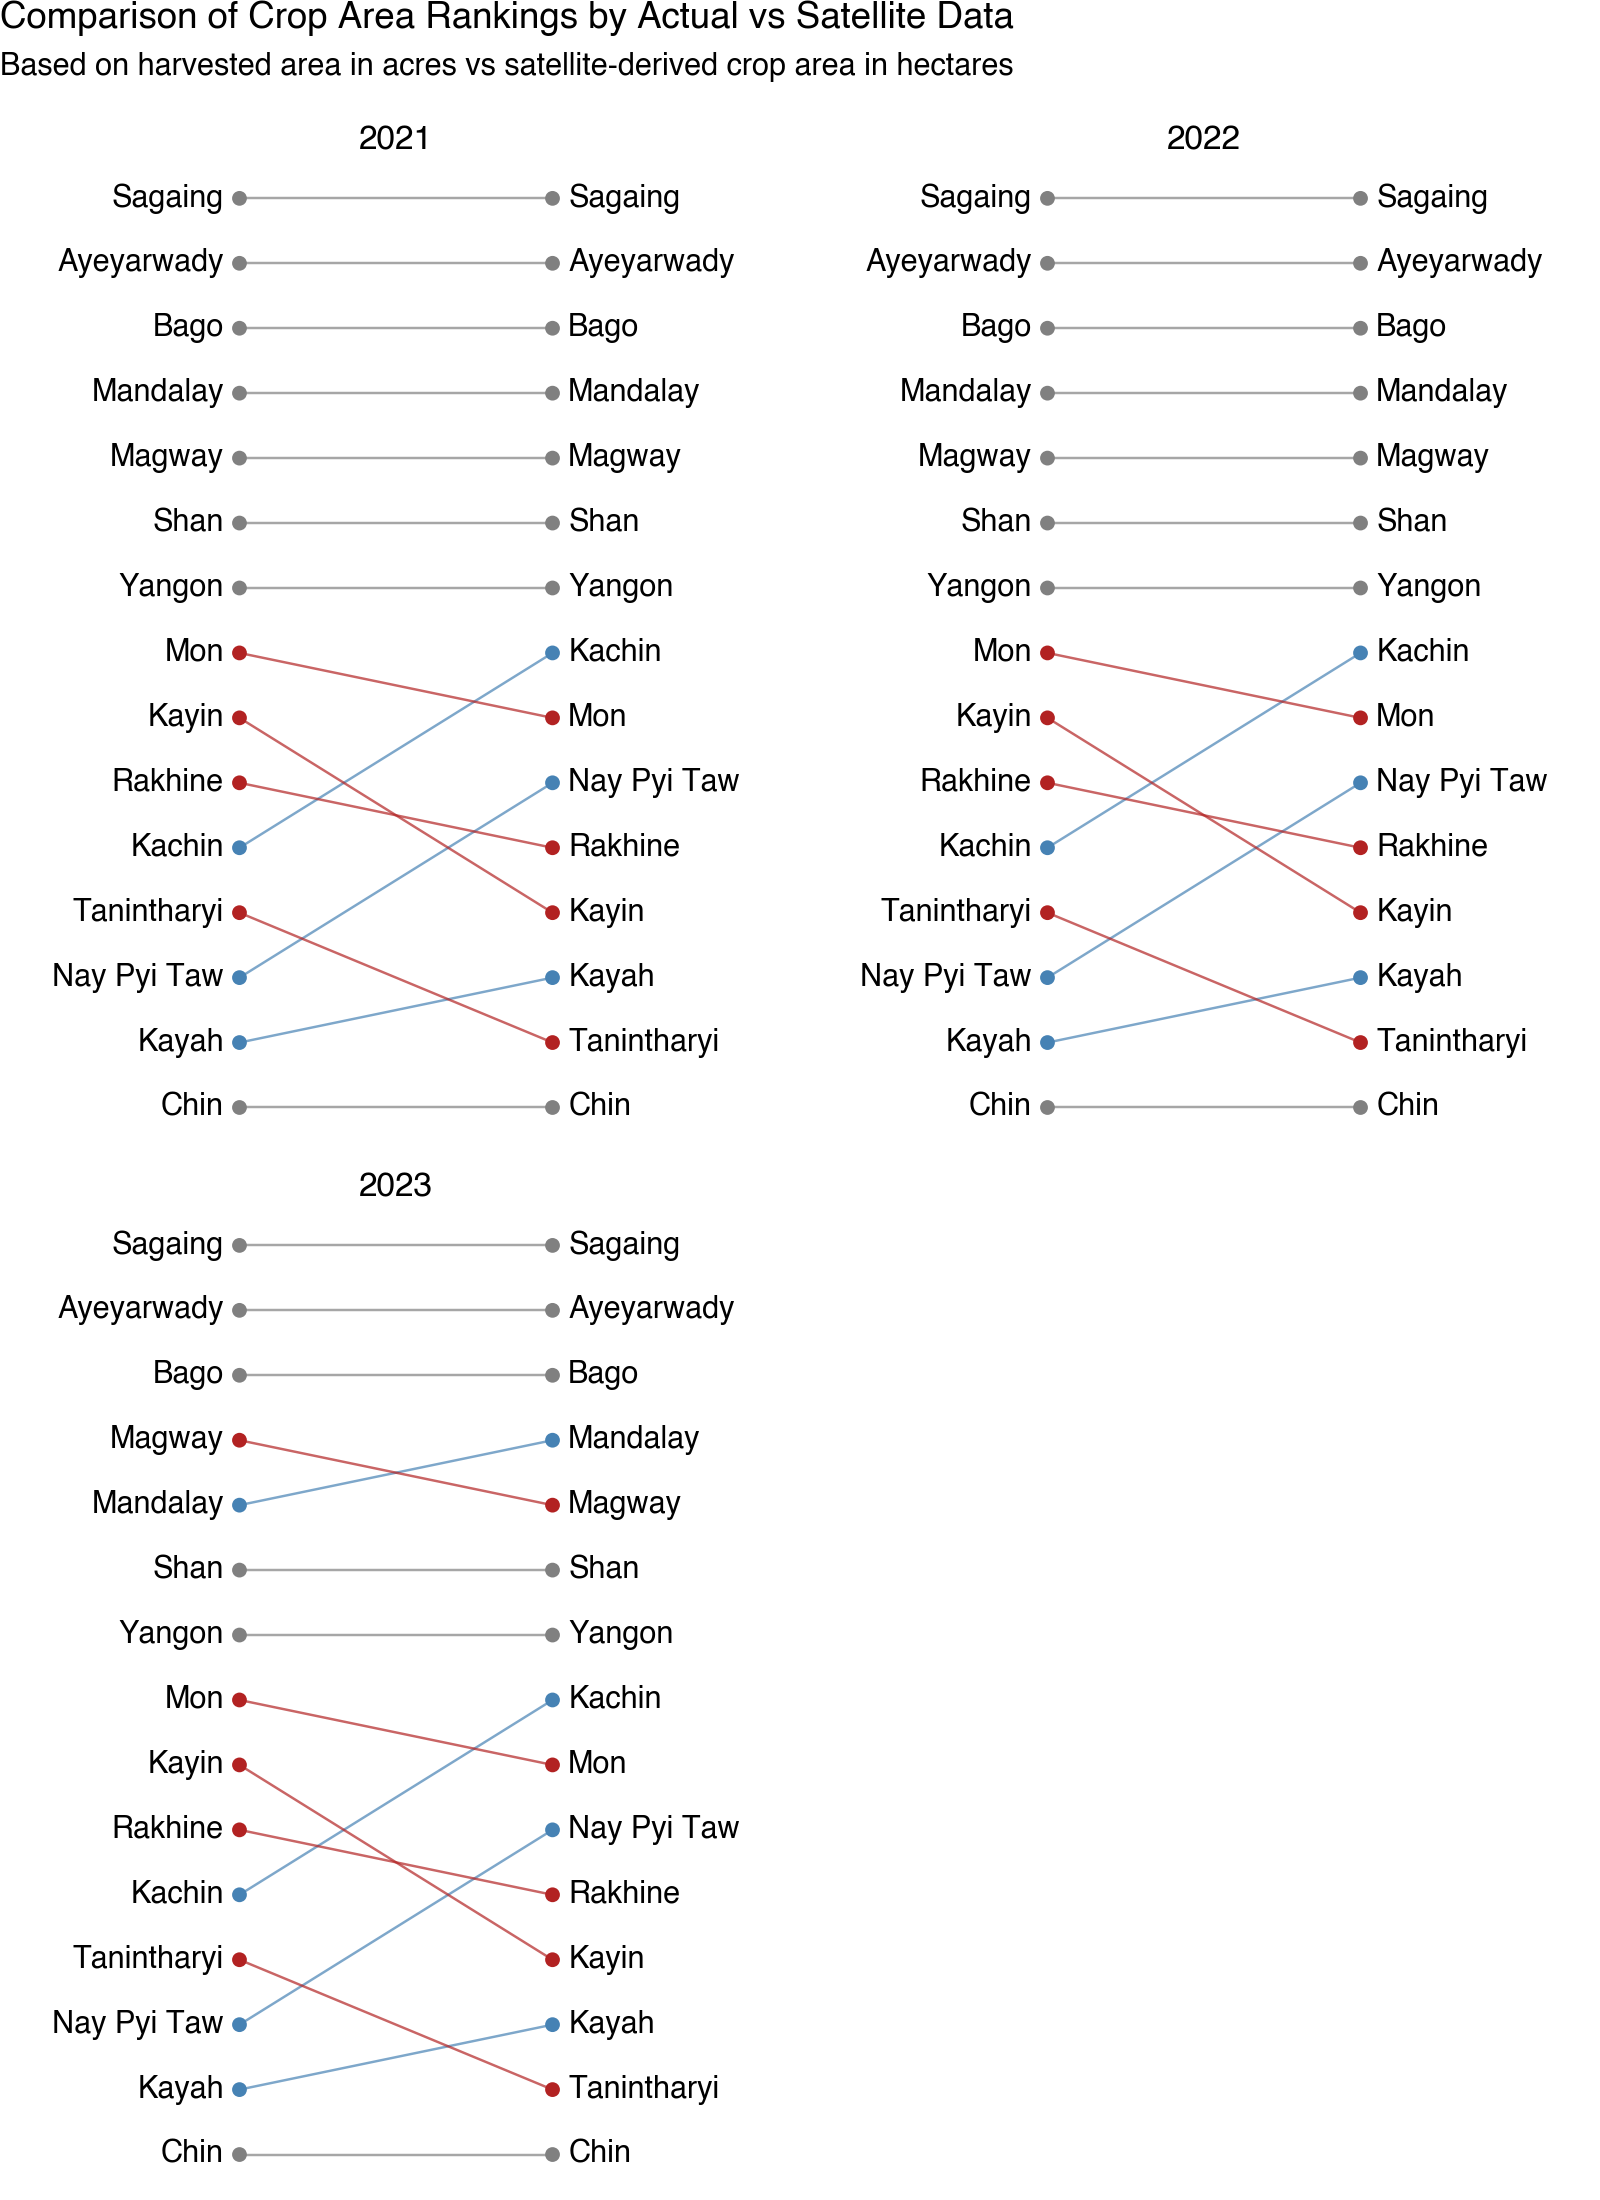

In [12]:
(
    crops_rank.assign(
        status=lambda df: np.where(
            df["satellite_rank"] < df["actual_rank"],
            "Actual Rank",
            np.where(
                df["satellite_rank"] > df["actual_rank"], "Satellite Rank", "Same Rank"
            ),
        )
    ).pipe((p9.ggplot, "data"))
    + p9.geom_text(
        p9.aes(1, "actual_rank", label="adm1_name"), nudge_x=-0.05, ha="right"
    )
    + p9.geom_text(
        p9.aes(2, "satellite_rank", label="adm1_name"), nudge_x=0.05, ha="left"
    )
    + p9.geom_point(
        p9.aes(x=1, y="actual_rank", color="status"),
        size=2,
    )
    + p9.geom_point(
        p9.aes(x=2, y="satellite_rank", color="status"),
        size=2,
    )
    + p9.geom_segment(
        p9.aes(
            x=1,
            y="actual_rank",
            xend=2,
            yend="satellite_rank",
            color="status",
        ),
        alpha=0.7,
    )
    + p9.scale_y_reverse()
    + p9.scale_color_manual(
        values={
            "Actual Rank": "steelblue",
            "Satellite Rank": "firebrick",
            "Same Rank": "gray",
        }
    )
    + p9.labs(
        x="",
        y="Rank (1 = Highest)",
        title="Comparison of Crop Area Rankings by Actual vs Satellite Data",
        subtitle="Based on harvested area in acres vs satellite-derived crop area in hectares",
    )
    + p9.facet_wrap("year", ncol=2)
    + p9.lims(x=(0.35, 2.65))
    + p9.theme_void()
    + p9.theme(
        figure_size=(8, 11),
        plot_subtitle=p9.element_text(margin={"b": 20}),
        legend_position="none",
        strip_text=p9.element_text(size=12),
    )
)

## Pre and Post 2021 coup d'état

The figure below shows the trend of EVI in Myanmar from 2012 to 2024, with a blue dotted line marking the 2021 coup d'état.

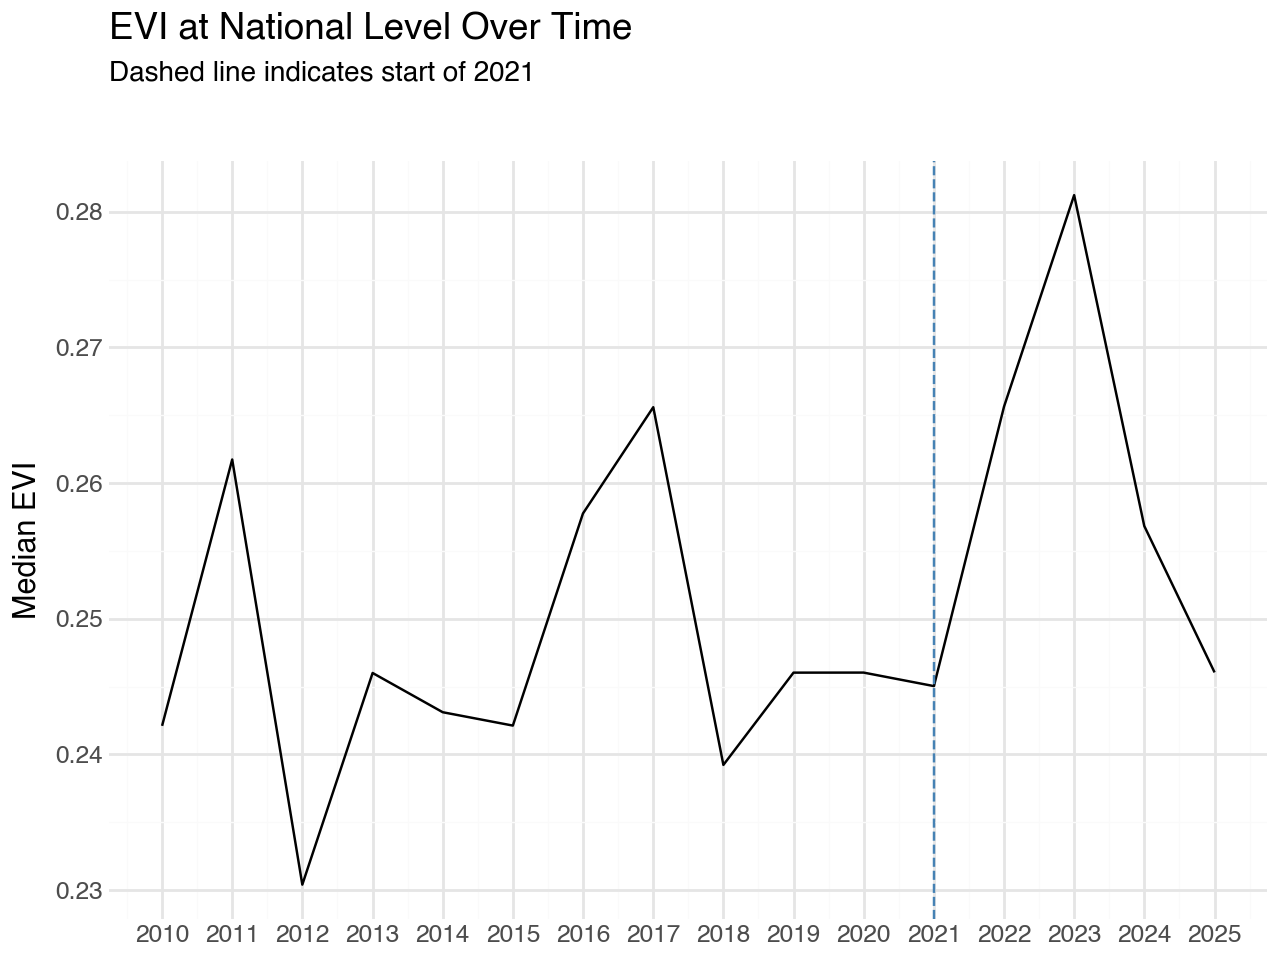

In [13]:
(
    evi_adm0_raw.groupby(pd.Grouper(freq="YS"))
    .agg({"EVI": "median"})
    .reset_index()
    .pipe(clean_names)
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="evi")
    + p9.geom_line()
    + p9.geom_vline(
        p9.aes(xintercept=pd.to_datetime("2021-01-01")),
        linetype="dashed",
        color="steelblue",
    )
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="1 year")
    + p9.theme_minimal()
    + p9.labs(
        title="EVI at National Level Over Time",
        subtitle="Dashed line indicates start of 2021",
        x="",
        y="Median EVI",
    )
    + p9.theme(
        plot_subtitle=p9.element_text(margin={"b": 20, "units": "pt"}, size=10),
    )
)

The figure below illustrates the trend of EVI values across administrative level 1 regions in Myanmar from 2012 to 2024, with a blue dotted line marking the 2021 coup d'état.

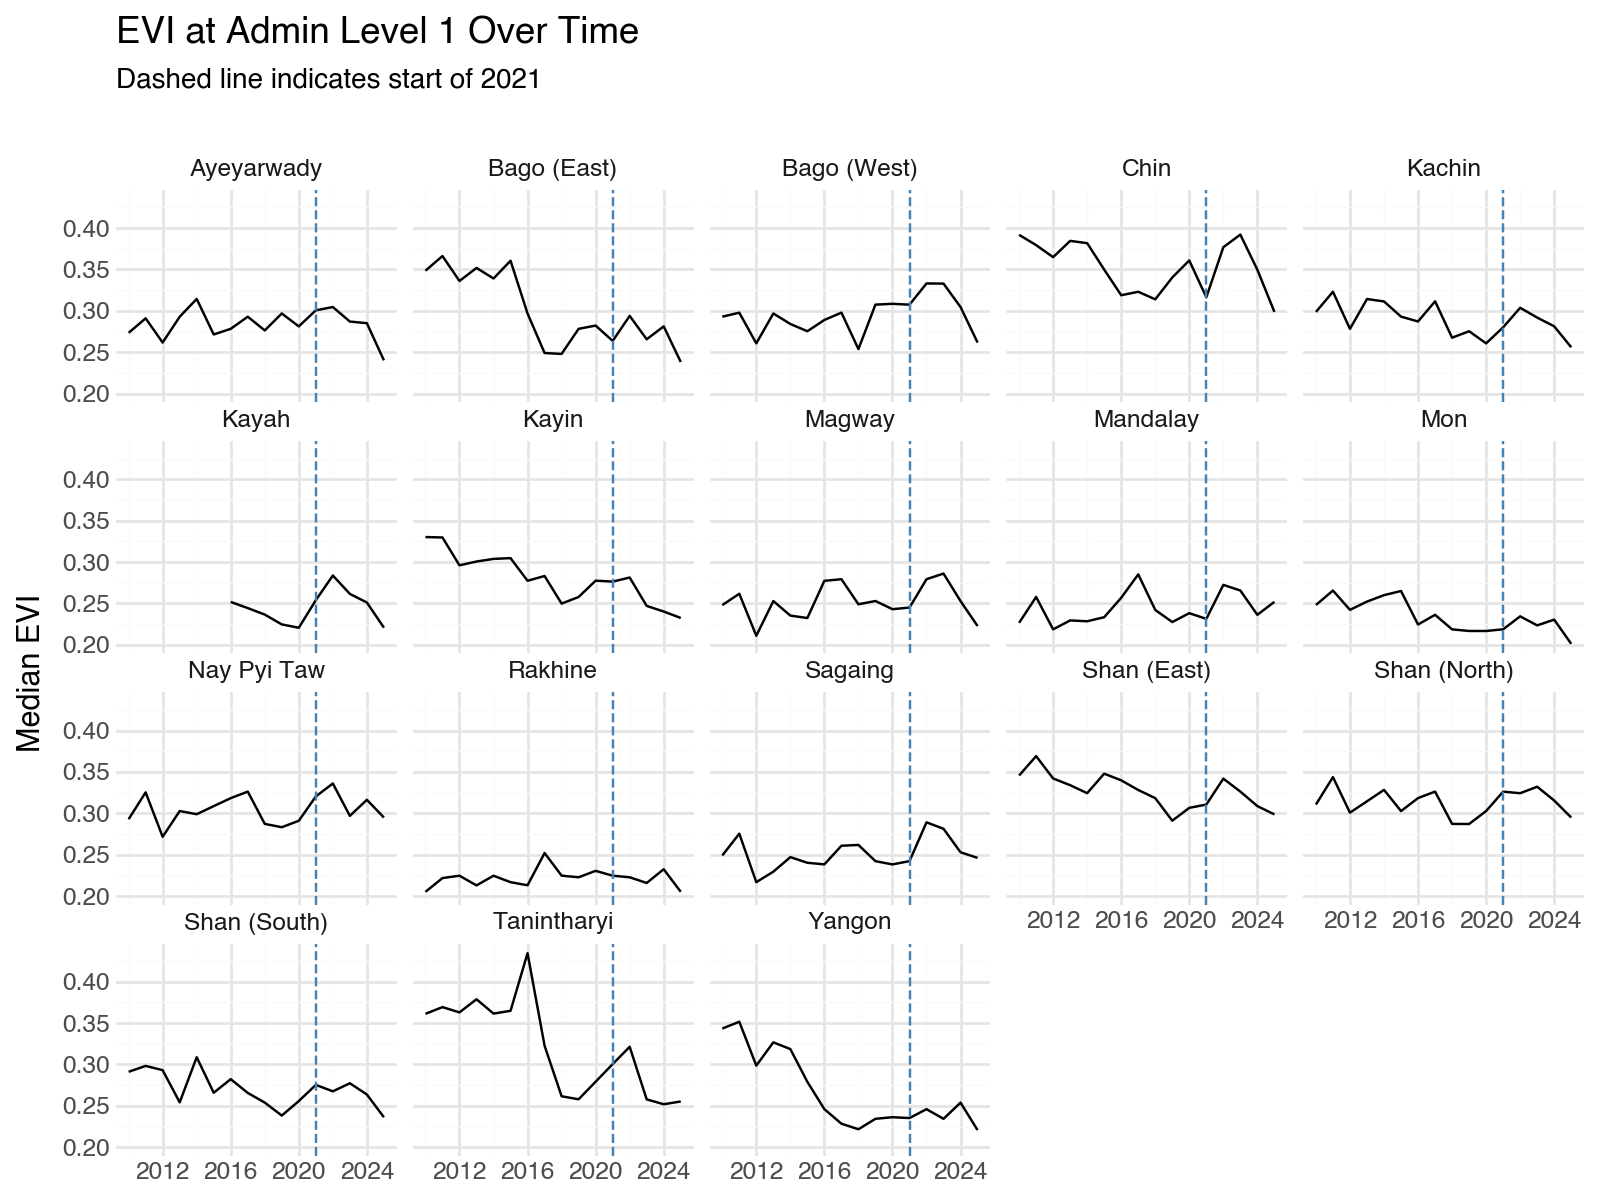

In [14]:
(
    evi_adm1_raw.groupby(["adm1_name", pd.Grouper(freq="YS")])
    .agg({"EVI": "median"})
    .reset_index()
    .pipe(clean_names)
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="evi")
    + p9.geom_line()
    + p9.geom_vline(
        p9.aes(xintercept=pd.to_datetime("2021-01-01")),
        linetype="dashed",
        color="steelblue",
    )
    + p9.facet_wrap("adm1_name")
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="4 year")
    + p9.theme_minimal()
    + p9.labs(
        title="EVI at Admin Level 1 Over Time",
        subtitle="Dashed line indicates start of 2021",
        x="",
        y="Median EVI",
    )
    + p9.theme(
        figure_size=(8, 6),
        plot_subtitle=p9.element_text(margin={"b": 20, "units": "pt"}, size=10),
    )
)

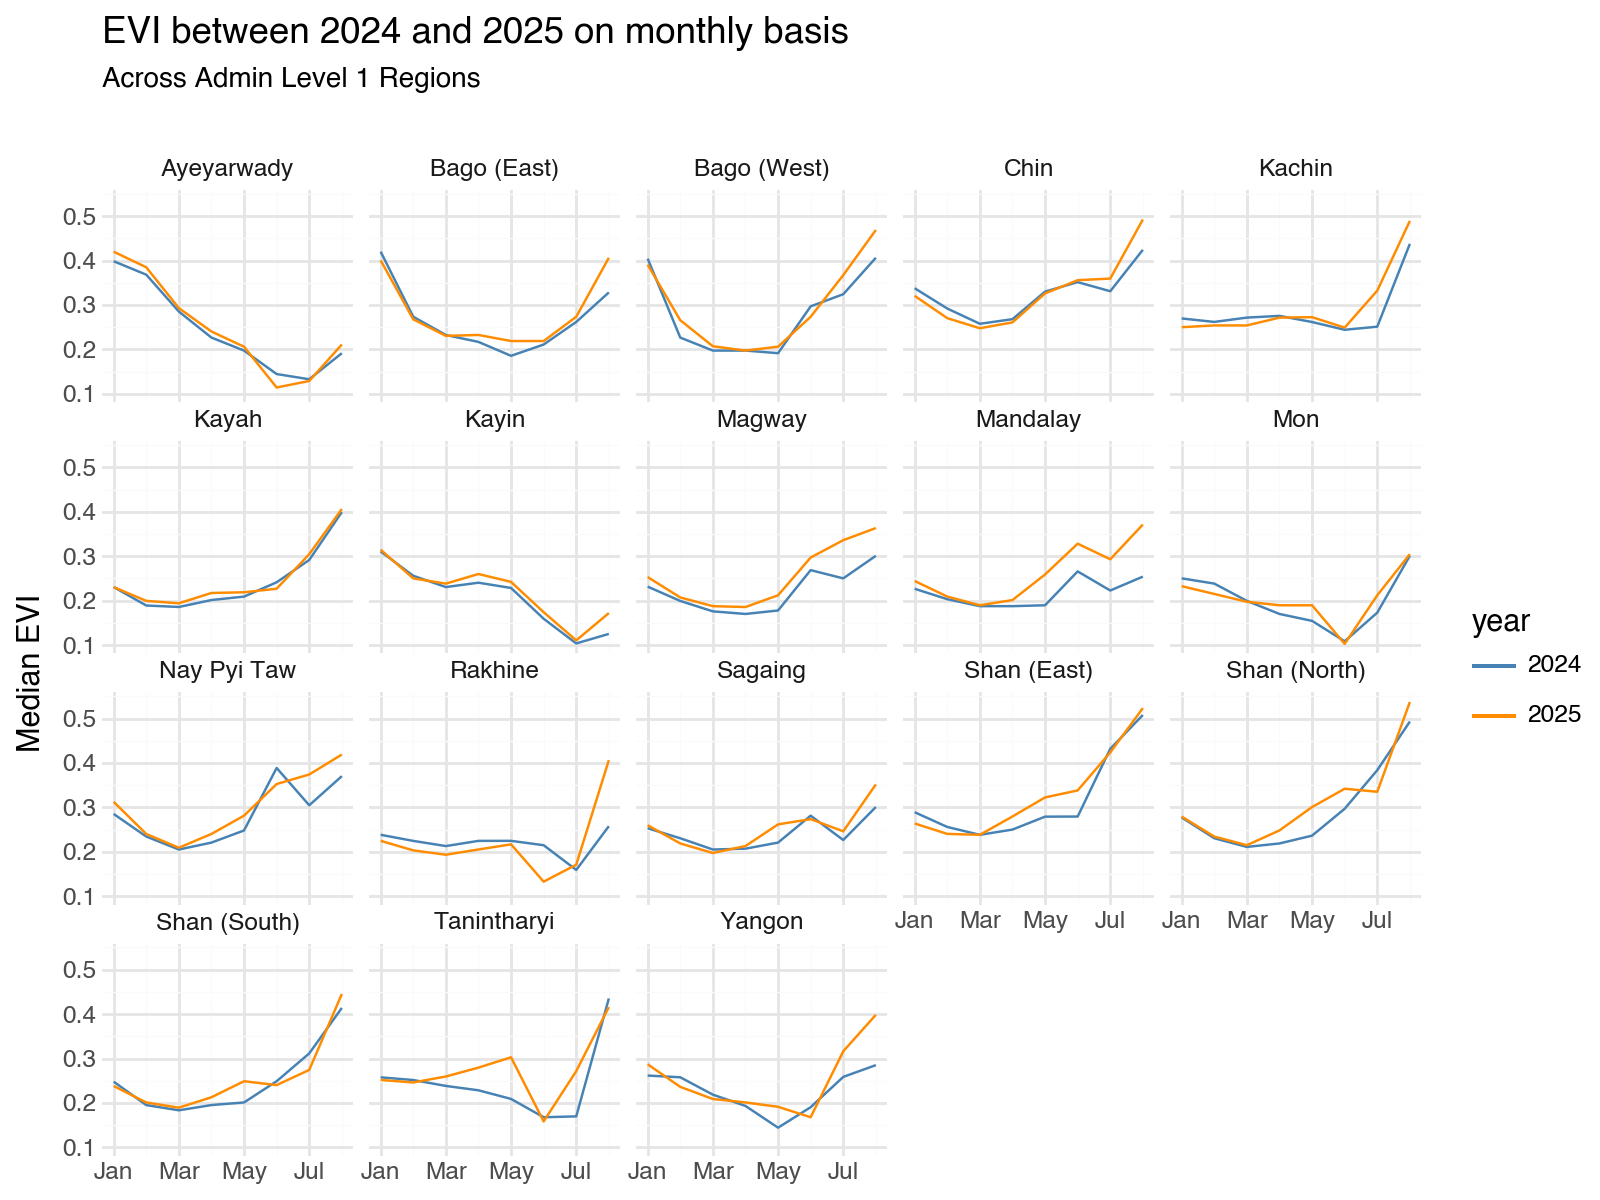

In [15]:
(
    evi_adm1_raw.groupby(["adm1_name", pd.Grouper(freq="MS")])
    .agg({"EVI": "median"})
    .reset_index()
    .pipe(clean_names)
    .assign(
        year=lambda df: df["date"].dt.year.astype(str),
        month=lambda df: df["date"].dt.month,
    )
    .query("date >= '2024-01-01' and month <= 8")
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="month", y="evi", color="year")
    + p9.geom_line()
    + p9.scale_x_continuous(
        breaks=list(range(1, 9, 2)),
        labels=[
            "Jan",
            "Mar",
            "May",
            "Jul",
        ],
    )
    + p9.scale_color_manual(values=["steelblue", "darkorange"])
    + p9.facet_wrap("adm1_name")
    + p9.theme_minimal()
    + p9.labs(
        title="EVI between 2024 and 2025 on monthly basis",
        subtitle="Across Admin Level 1 Regions",
        x="",
        y="Median EVI",
    )
    + p9.theme(
        figure_size=(8, 6),
        plot_subtitle=p9.element_text(margin={"b": 20, "units": "pt"}, size=10),
    )
)

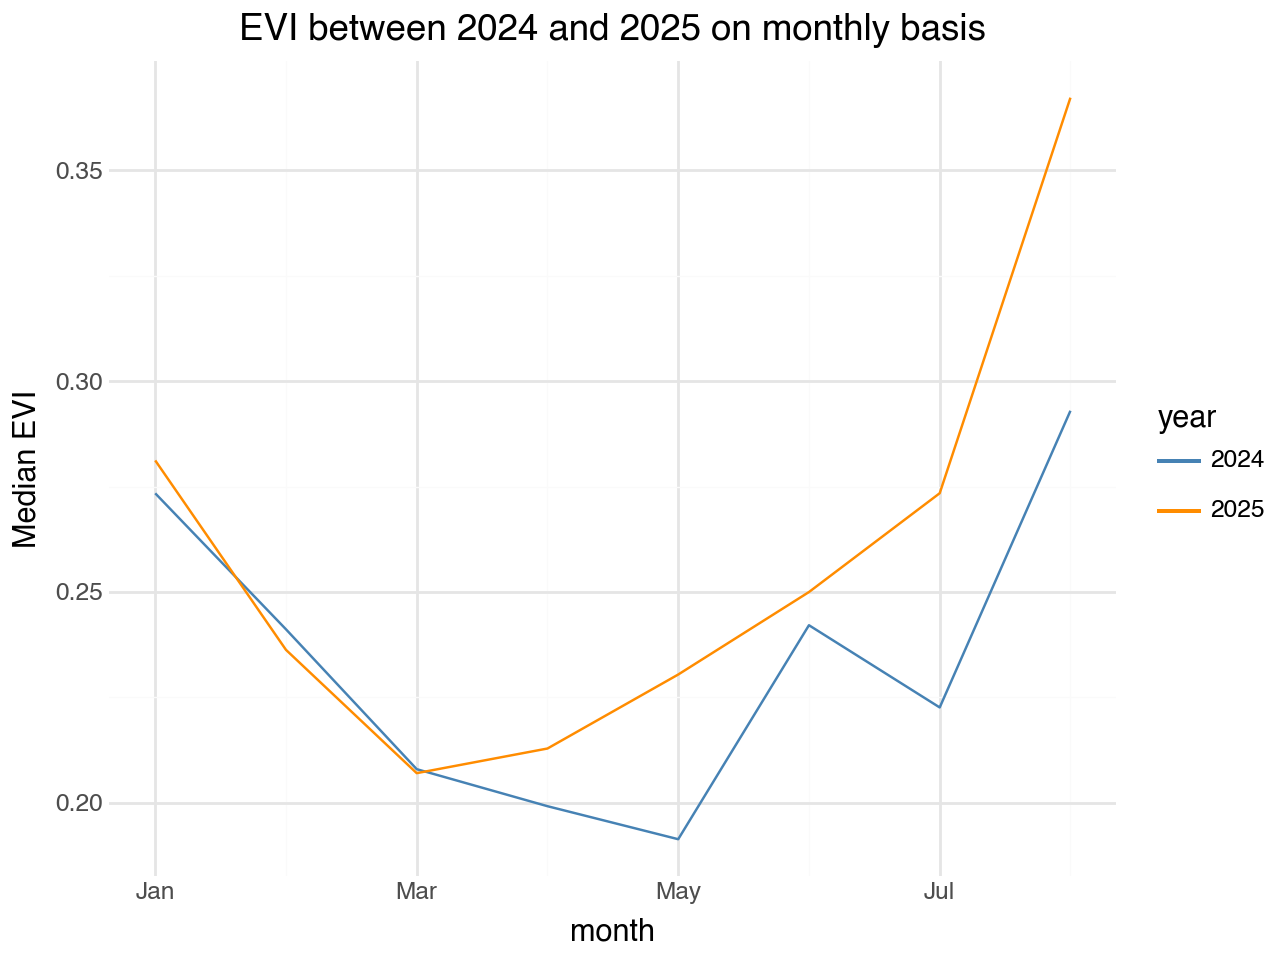

In [16]:
(
    evi_adm0_raw.groupby(pd.Grouper(freq="MS"))
    .agg({"EVI": "median"})
    .reset_index()
    .pipe(clean_names)
    .assign(
        year=lambda df: df["date"].dt.year.astype(str),
        month=lambda df: df["date"].dt.month,
    )
    .query("date >= '2024-01-01' and month <= 8")
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="month", y="evi", color="year")
    + p9.geom_line()
    + p9.scale_x_continuous(
        breaks=list(range(1, 9, 2)),
        labels=[
            "Jan",
            "Mar",
            "May",
            "Jul",
        ],
    )
    + p9.scale_color_manual(values=["steelblue", "darkorange"])
    + p9.theme_minimal()
    + p9.labs(
        title="EVI between 2024 and 2025 on monthly basis",
        y="Median EVI",
    )
)

## GDP and EVI

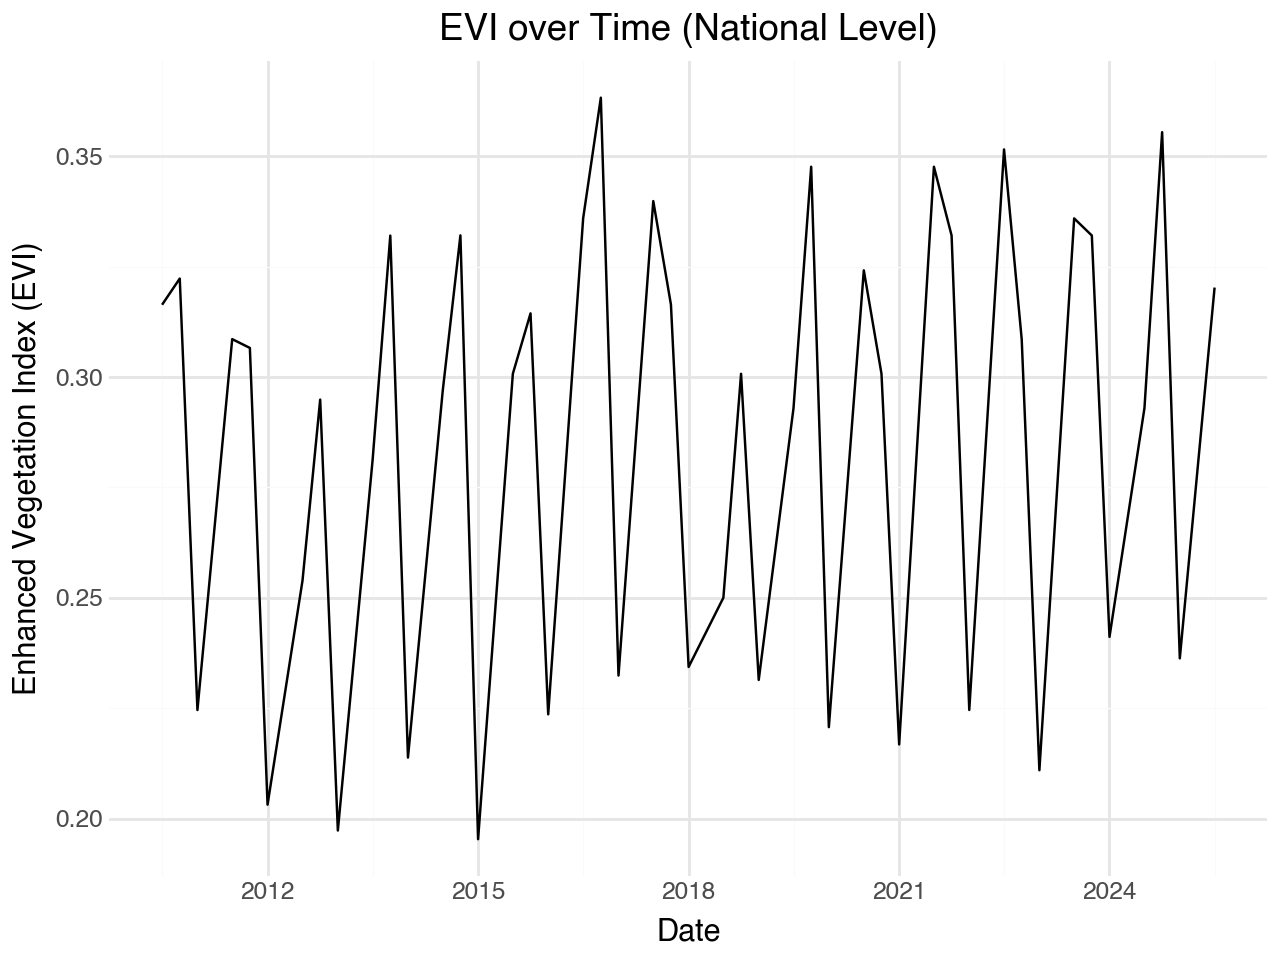

In [17]:
(
    evi_adm0.reset_index()
    .pipe(filter_growing_season)
    .query("year >= '2010-01-01'")
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="evi")
    + p9.geom_line()
    + p9.scale_x_datetime(date_labels="%Y", date_breaks="3 year")
    + p9.labs(
        title="EVI over Time (National Level)",
        x="Date",
        y="Enhanced Vegetation Index (EVI)",
    )
    + p9.theme_minimal()
)

### Admin Level 0

In [18]:
evi_indicators = (
    gdp_agri_quarterly.join(evi_adm0, how="left")
    .join(ntl_adm0, how="left")
    .reset_index()
    .assign(
        evi_lag_1=lambda df: df["evi"].shift(1),
        evi_lag_2=lambda df: df["evi"].shift(2),
        ntl_mean_lag_1=lambda df: df["ntl_mean"].shift(1),
        evi_std=lambda df: StandardScaler().fit_transform(df[["evi"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
        evi_lag_1_std=lambda df: StandardScaler().fit_transform(df[["evi_lag_1"]]),
        evi_lag_2_std=lambda df: StandardScaler().fit_transform(df[["evi_lag_2"]]),
        is_crop_season=lambda df: df["date"].dt.month.isin([7, 8, 9, 10, 11, 12, 1, 2]),
    )
    .set_index("date")
)

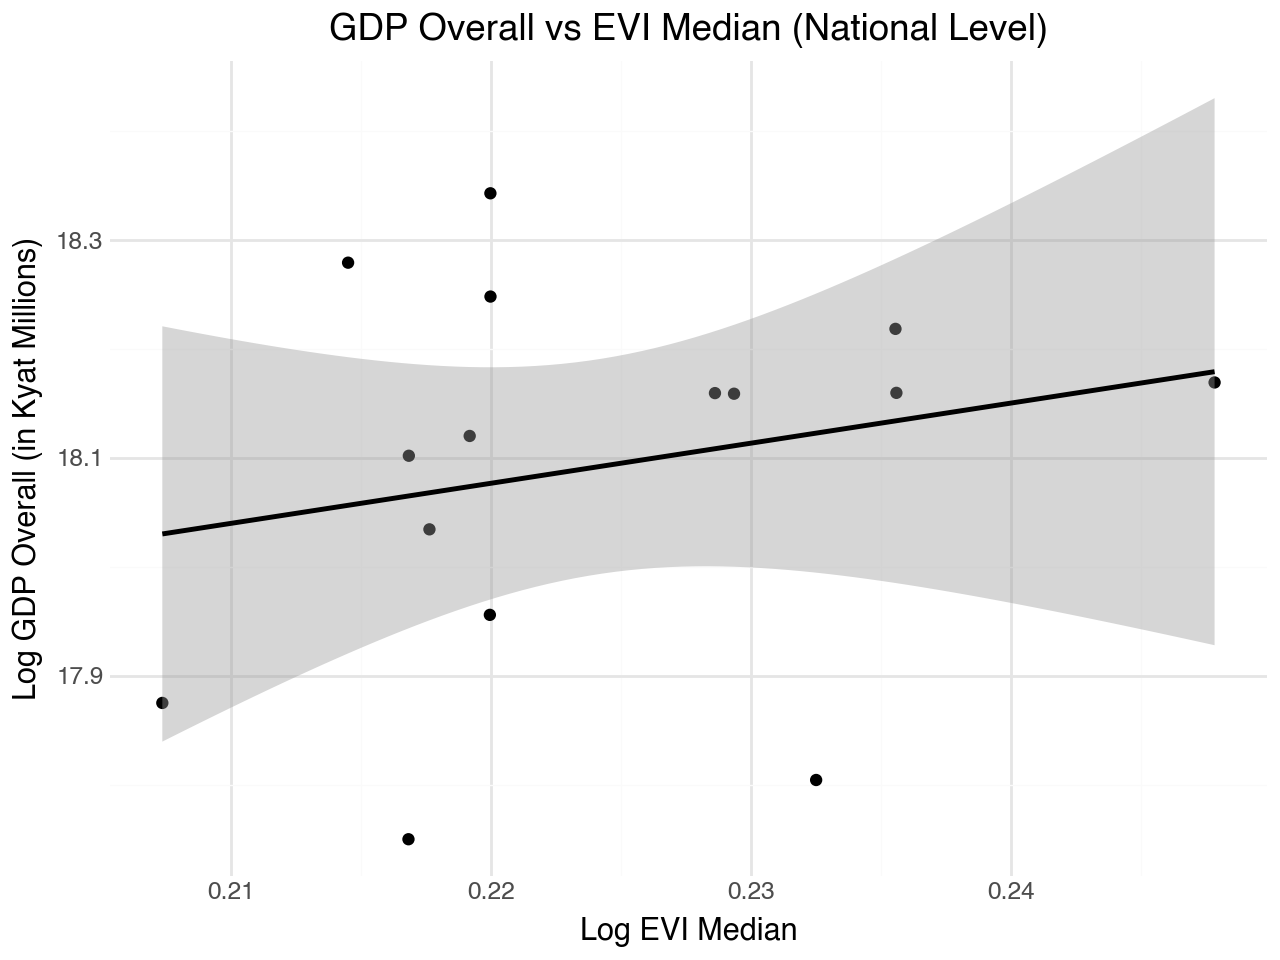

In [19]:
evi_adm0_annual = (
    evi_adm0_raw.groupby(pd.Grouper(freq="YS")).agg({"EVI": "median"}).pipe(clean_names)
)

(
    evi_adm0_annual.join(gdp_overall, how="inner")
    .reset_index()
    .assign(
        evi_log=lambda df: np.log1p(df["evi"]),
        gdp_overall_log=lambda df: np.log1p(df["gdp_overall"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="evi_log", y="gdp_overall_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Overall vs EVI Median (National Level)",
        x="Log EVI Median",
        y="Log GDP Overall (in Kyat Millions)",
    )
    + p9.theme_minimal()
)

In [20]:
model_gdp_evi_overall_log = smf.ols(
    "np.log1p(gdp_overall) ~ np.log1p(evi)",
    data=evi_adm0_annual.join(gdp_overall, how="inner"),
).fit()

model_gdp_evi_overall_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log1p(gdp_overall)   R-squared:                       0.049
Model:                               OLS   Adj. R-squared:                 -0.024
Method:                    Least Squares   F-statistic:                    0.6670
Date:                   Wed, 29 Oct 2025   Prob (F-statistic):              0.429
Time:                           15:08:06   Log-Likelihood:                 5.7683
No. Observations:                     15   AIC:                            -7.537
Df Residuals:                         13   BIC:                            -6.120
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.2666      1.011     17.071      0.000      15.081      19.452
np.log1p(evi)     3.6825      4.509      0.817      0.429      -6.058      13.423
==============================================================================
Omnibus:                        1.052   Durbin-Watson:                   0.228
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                0.683
Skew:                          -0.495   Prob(JB):                        0.711
Kurtosis:                       2.663   Cond. No.                         104.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

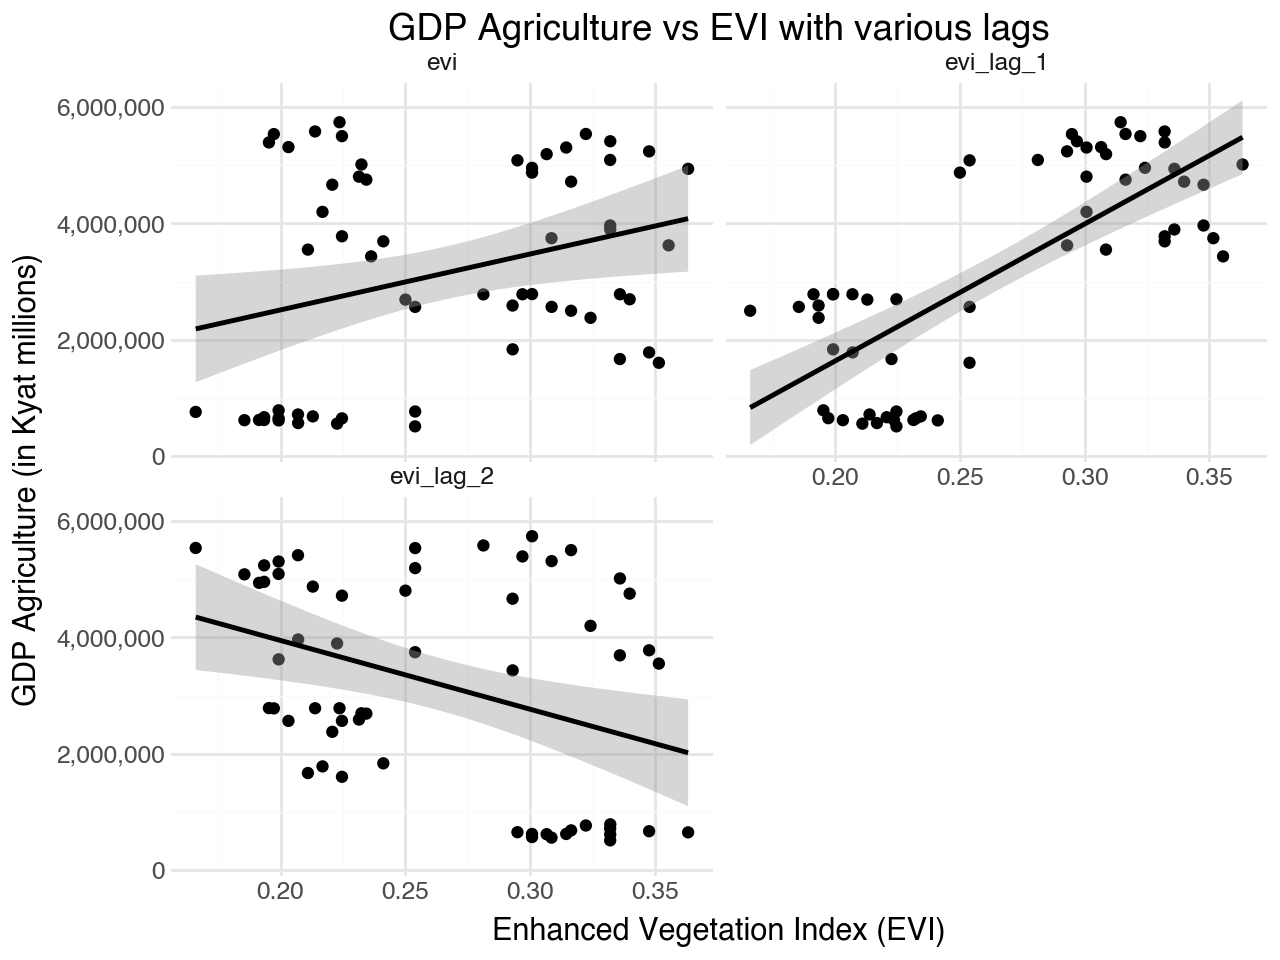

In [21]:
(
    evi_indicators.filter(["gdp_agri", "evi", "evi_lag_1", "evi_lag_2"])
    .reset_index()
    .melt(id_vars=["gdp_agri", "date"])
    .dropna(subset=["value"])
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="GDP Agriculture vs EVI with various lags",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture (in Kyat millions)",
    )
    + p9.theme_minimal()
)

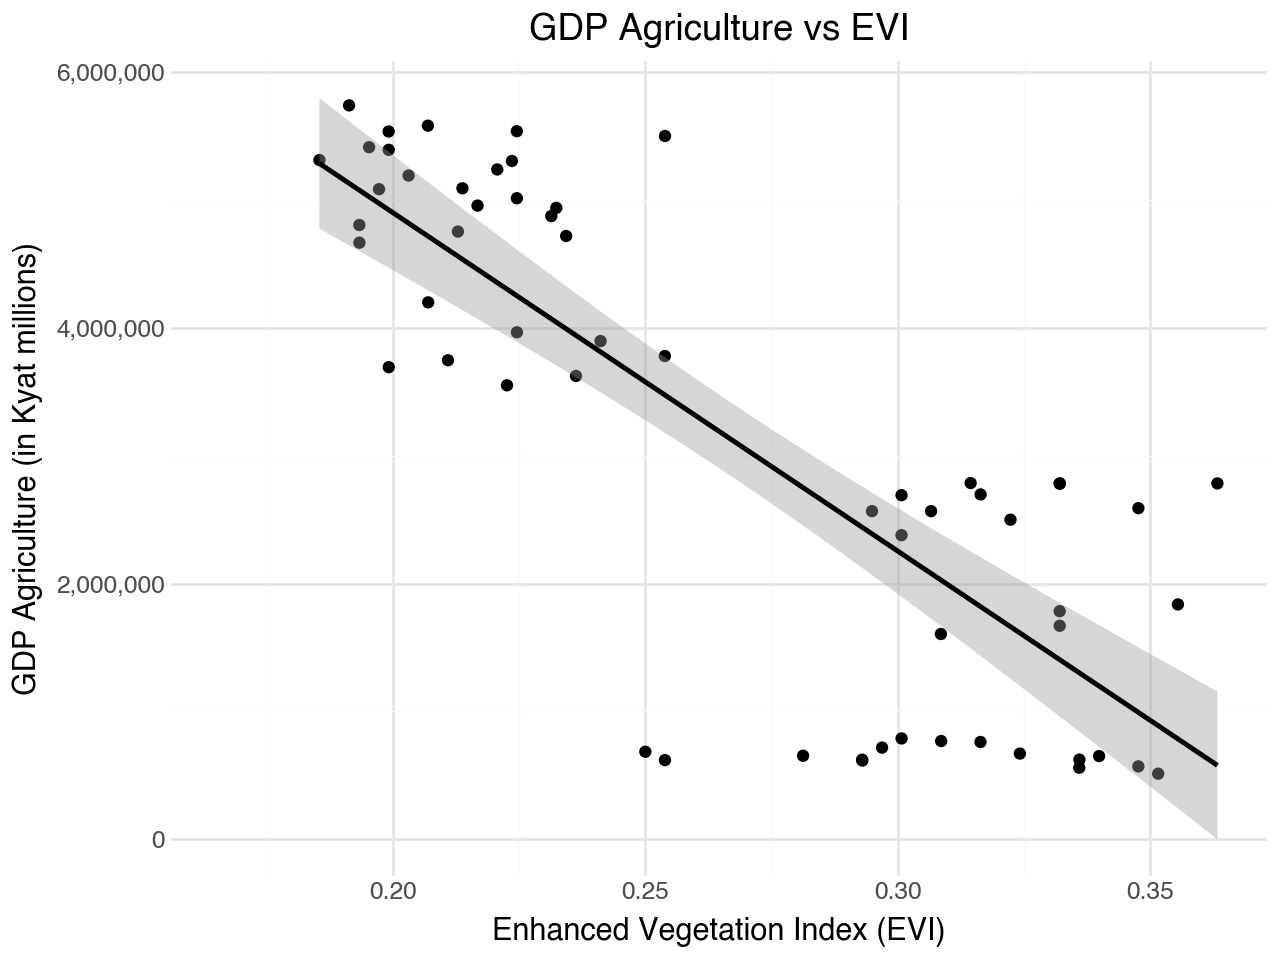

In [22]:
(
    evi_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="gdp_agri_lag_1")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs EVI",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture (in Kyat millions)",
    )
    + p9.theme_minimal()
)

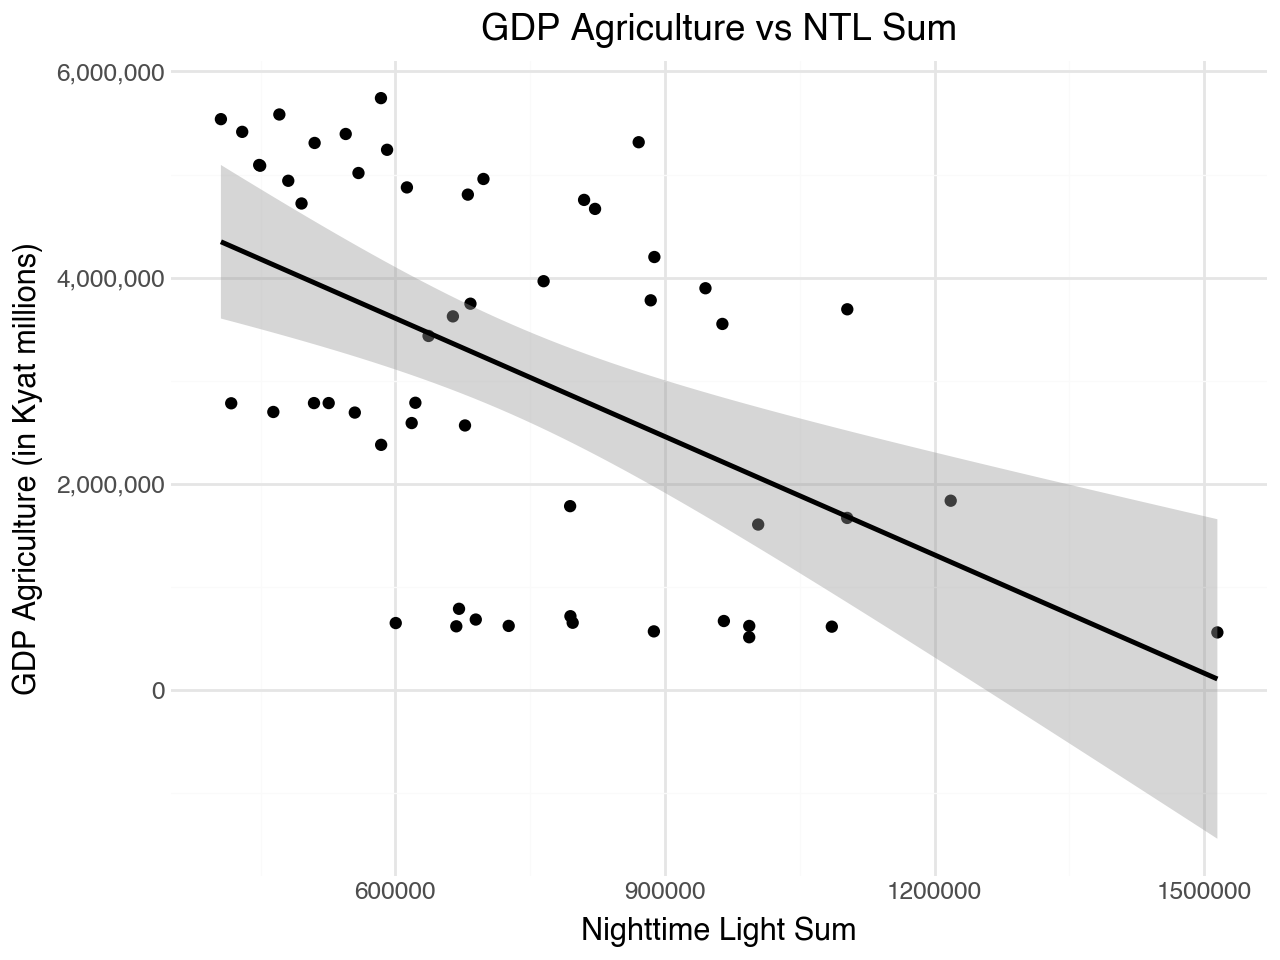

In [23]:
(
    evi_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_agri")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs NTL Sum",
        x="Nighttime Light Sum",
        y="GDP Agriculture (in Kyat millions)",
    )
    + p9.theme_minimal()
)

The following figure illustrates the correlation matrix between EVI, Nighttime Lights, and Overall GDP at national level.

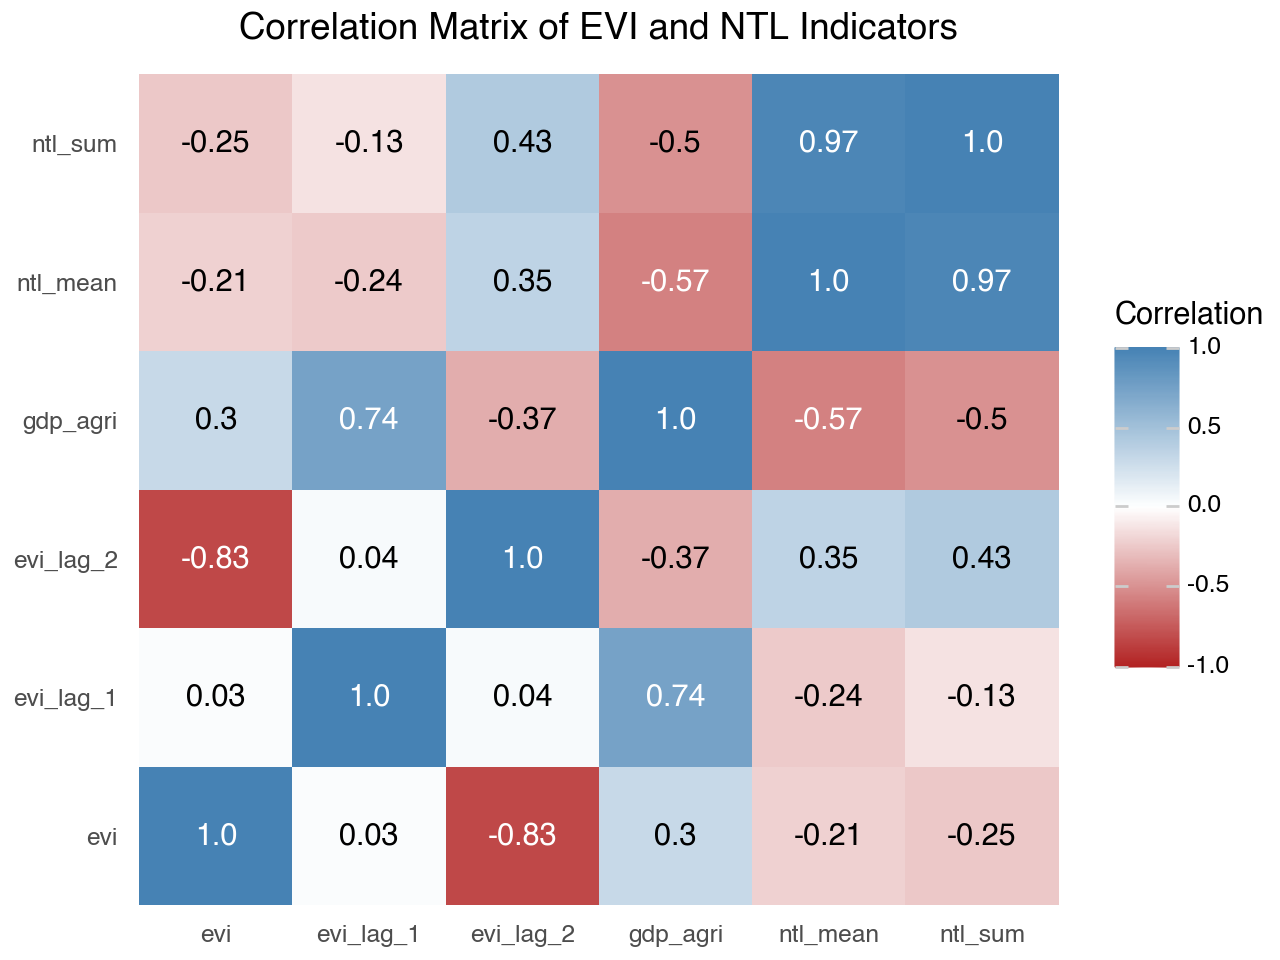

In [24]:
(
    evi_indicators.filter(
        [
            "gdp_agri",
            "evi",
            "evi_lag_1",
            "evi_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(
        title="Correlation Matrix of EVI and NTL Indicators",
        fill="Correlation",
        x="",
        y="",
    )
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [25]:
mod_1 = smf.ols("gdp_agri ~ evi", data=evi_indicators).fit()
mod_2 = smf.ols("gdp_agri ~ ntl_sum + evi", data=evi_indicators).fit()
mod_3 = smf.ols("gdp_agri ~ ntl_sum + evi + evi_lag_1", data=evi_indicators).fit()

Stargazer([mod_1, mod_2, mod_3])

In [26]:
mod_1 = smf.ols("np.log1p(gdp_agri) ~ np.log1p(evi)", data=evi_indicators).fit()
mod_2 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi)",
    data=evi_indicators,
).fit()
mod_3 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi) + np.log1p(evi_lag_1)",
    data=evi_indicators,
).fit()

Stargazer([mod_1, mod_2, mod_3])

In [27]:
mod_1 = smf.ols("np.log1p(gdp_agri) ~ np.log1p(evi)", data=evi_indicators).fit()
mod_2 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi) + is_crop_season",
    data=evi_indicators,
).fit()
mod_3 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi) + np.log1p(evi_lag_1) + is_crop_season",
    data=evi_indicators,
).fit()

Stargazer([mod_1, mod_2, mod_3])

The figure below visualizes feature importance and effects across all samples in your dataset. Each dot represents one sample or observation, with color indicating the feature value (red for high values, blue for low values). The relationship between feature values and effects is revealed through color patterns: if red dots cluster on the right, high feature values lead to higher predictions, while if blue dots cluster on the right, low feature values increase predictions.

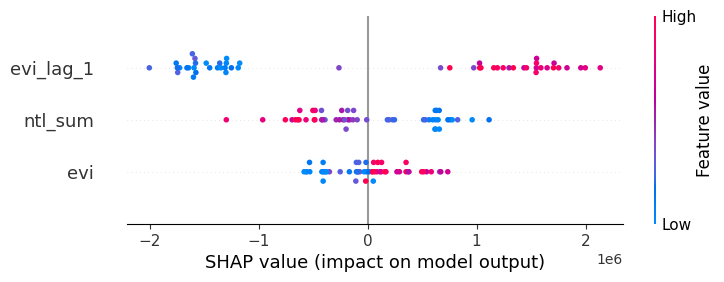

In [28]:
evi_indicators_clean = evi_indicators.dropna()
X = evi_indicators_clean[["evi", "ntl_sum", "evi_lag_1"]]
y = evi_indicators_clean["gdp_agri"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

### Admin Level 1

The Sectoral GDP at admin level 1 for all years was estimated based on the sectoral GDP proportions observed in 2015-2016. The proportions were assumed to remain constant over the years as shown below:

In [29]:
(
    gdp_adm1.filter(["adm1_name", "agriculture_pct", "industry_pct", "services_pct"])
    .assign(
        agriculture_pct=lambda df: df["agriculture_pct"].apply(
            lambda x: "{:.1f}%".format(x * 100)
        ),
        industry_pct=lambda df: df["industry_pct"].apply(
            lambda x: "{:.1f}%".format(x * 100)
        ),
        services_pct=lambda df: df["services_pct"].apply(
            lambda x: "{:.1f}%".format(x * 100)
        ),
    )
    .rename(
        columns={
            "agriculture_pct": "Agriculture",
            "industry_pct": "Industry",
            "services_pct": "Services",
        }
    )
)

adm1_name Agriculture Industry Services
0     Ayeyarwady       16.0%     5.1%    10.1%
1           Chin        0.5%     0.3%     0.3%
2         Kachin        2.1%     1.9%     1.8%
3          Kayah        0.5%     0.2%     0.3%
4          Kayin        2.4%     1.3%     1.9%
5         Magway       14.1%     7.9%     7.4%
6       Mandalay        8.3%    12.3%    12.5%
7            Mon        4.4%     4.1%     4.3%
8    Nay Pyi Taw        1.1%     1.7%     3.3%
9        Rakhine        3.3%     2.6%     4.6%
10       Sagaing       17.0%    12.8%     8.2%
11   Tanintharyi        6.9%     2.0%     2.5%
12        Yangon        4.9%    35.4%    28.5%
13   Bago (East)        5.3%     3.7%     4.2%
14   Bago (West)        5.3%     3.7%     4.2%
15  Shan (South)        2.7%     1.7%     2.0%
16   Shan (East)        2.7%     1.7%     2.0%
17  Shan (North)        2.7%     1.7%     2.0%

In [30]:
evi_indicators_adm1 = (
    gdp_agri_quarterly_adm1.join(evi_adm1, how="left")
    .join(ntl_adm1, how="left")
    .assign(
        gdp_agri_c=lambda df: df["gdp_agri"] - df["gdp_agri"].mean(),
        evi_std=lambda df: StandardScaler().fit_transform(df[["evi"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
    )
    .reset_index()
    .sort_values(["adm1_name", "date"])
    .groupby("adm1_name")
    .apply(
        lambda df: df.assign(
            evi_lag_1=df["evi"].shift(1),
            evi_lag_2=df["evi"].shift(2),
            evi_lag_1_std=lambda dff: StandardScaler().fit_transform(
                dff[["evi_lag_1"]]
            ),
            evi_lag_2_std=lambda dff: StandardScaler().fit_transform(
                dff[["evi_lag_2"]]
            ),
            ntl_sum_lag_1=df["ntl_sum"].shift(1),
            ntl_sum_lag_2=df["ntl_sum"].shift(2),
        ),
    )
    .set_index(["adm1_name", "date"])
)

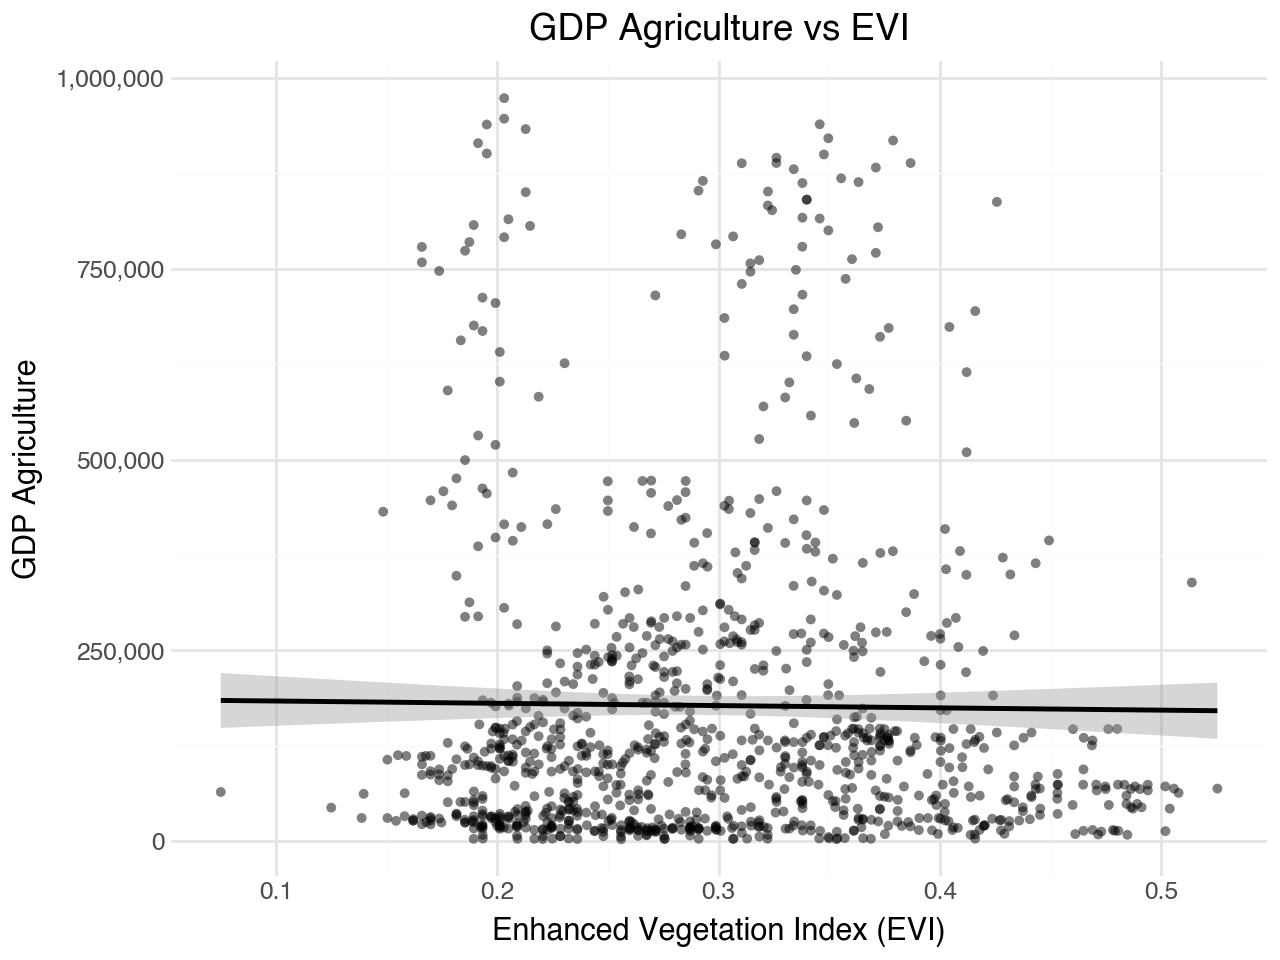

In [31]:
(
    evi_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="gdp_agri")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs EVI",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

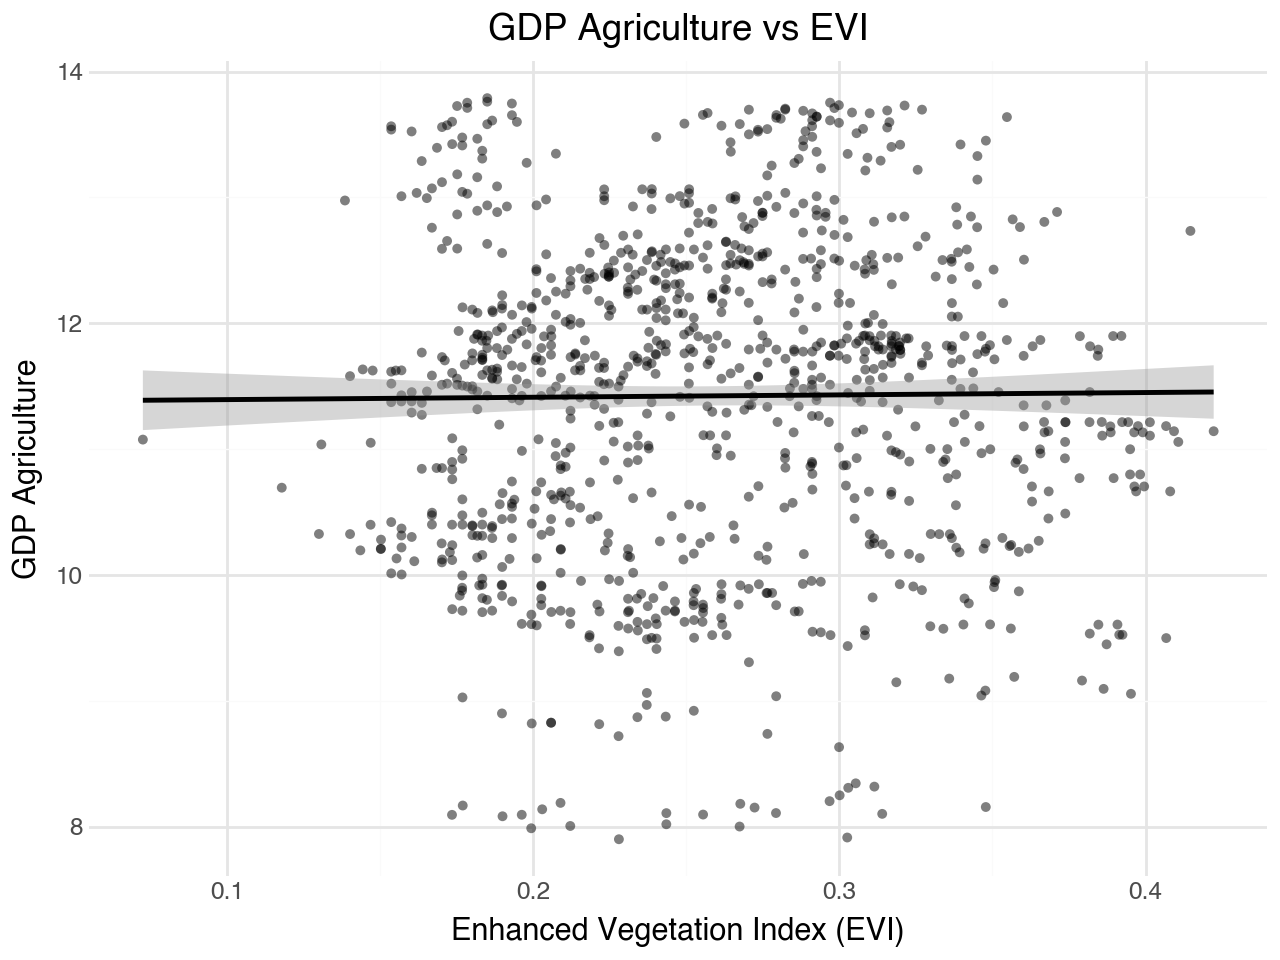

In [32]:
(
    evi_indicators_adm1.assign(
        evi_log=lambda df: np.log1p(df["evi"]),
        gdp_agri_log=lambda df: np.log1p(df["gdp_agri"]),
    ).pipe((p9.ggplot, "data"))
    + p9.aes(x="evi_log", y="gdp_agri_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs EVI",
        x="Enhanced Vegetation Index (EVI)",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

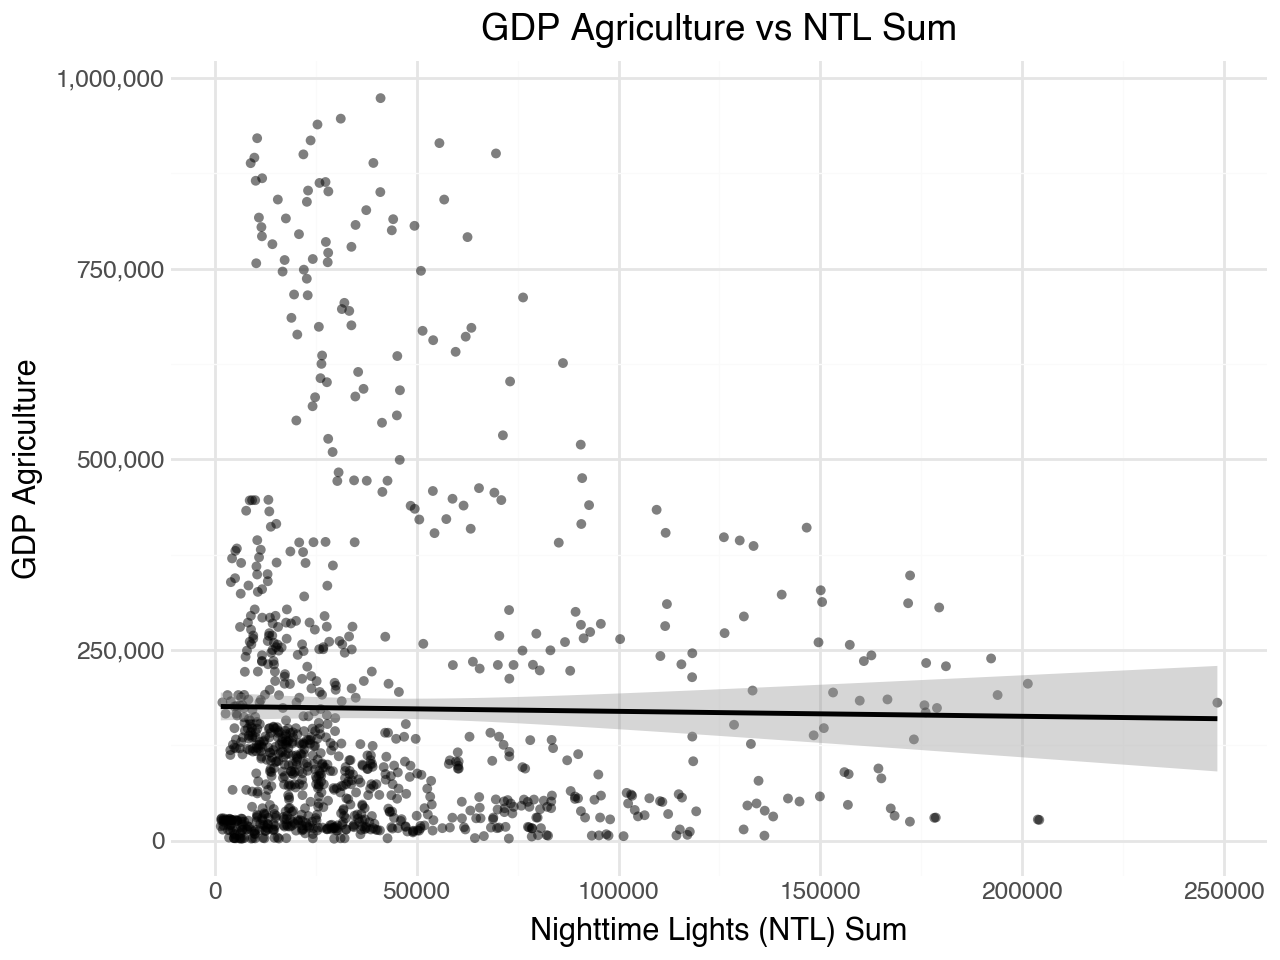

In [33]:
(
    evi_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_agri")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Agriculture vs NTL Sum",
        x="Nighttime Lights (NTL) Sum",
        y="GDP Agriculture",
    )
    + p9.theme_minimal()
)

The following figures show the correlation matrix between EVI, Nighttime Lights, and Sectoral GDP (Manufacturing and Services) at admin level 1.

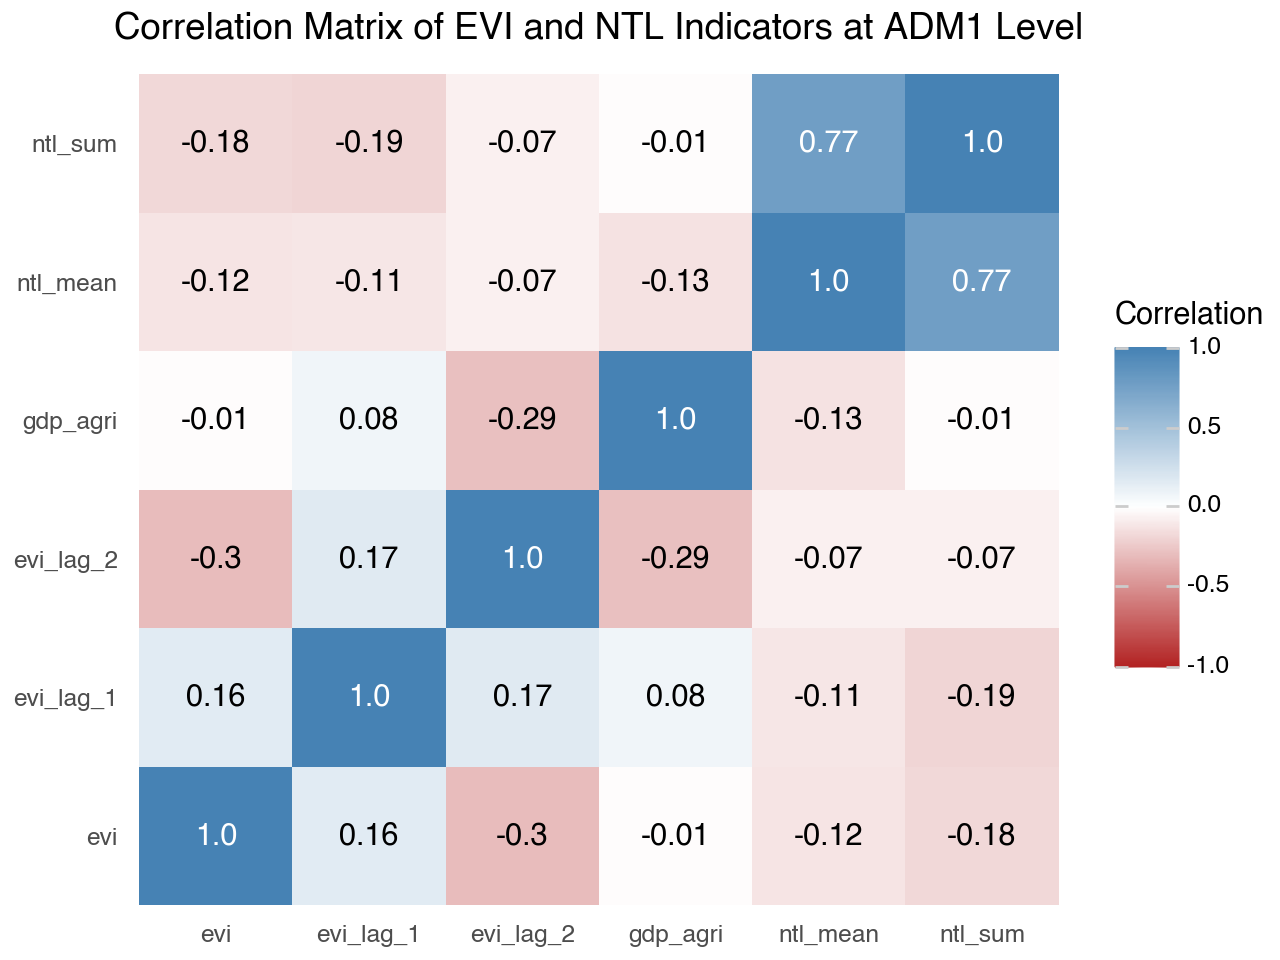

In [34]:
(
    evi_indicators_adm1.filter(
        [
            "gdp_agri",
            "evi",
            "evi_lag_1",
            "evi_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(
        title="Correlation Matrix of EVI and NTL Indicators at ADM1 Level",
        fill="Correlation",
        x="",
        y="",
    )
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [35]:
mod_1 = smf.ols("np.log1p(gdp_agri) ~ np.log1p(evi)", data=evi_indicators_adm1).fit()
mod_2 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi)", data=evi_indicators_adm1
).fit()
mod_3 = smf.ols(
    "np.log1p(gdp_agri) ~ np.log1p(ntl_sum) + np.log1p(evi) + np.log1p(evi_lag_1)",
    data=evi_indicators_adm1,
).fit()

Stargazer([mod_1, mod_2, mod_3])

The figure below visualizes feature importance and effects across all samples in your dataset. Each dot represents one sample or observation, with color indicating the feature value (red for high values, blue for low values). The relationship between feature values and effects is revealed through color patterns: if red dots cluster on the right, high feature values lead to higher predictions, while if blue dots cluster on the right, low feature values increase predictions.

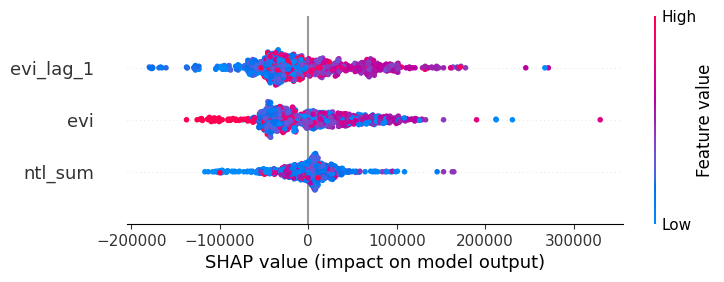

In [36]:
evi_indicators_adm_1_clean = evi_indicators_adm1.dropna()
X = evi_indicators_adm_1_clean[["evi", "ntl_sum", "evi_lag_1"]]
y = evi_indicators_adm_1_clean["gdp_agri"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

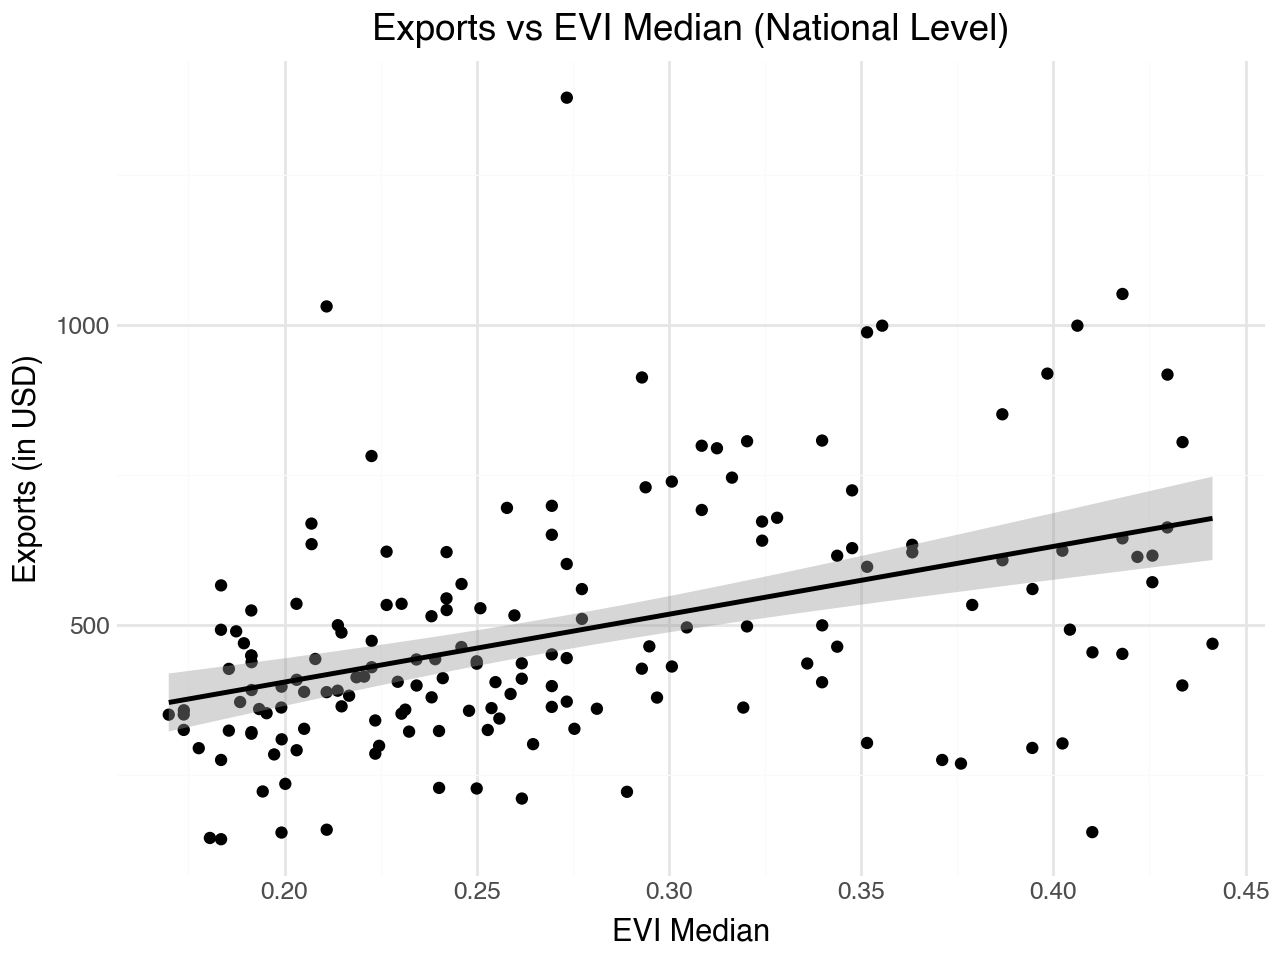

In [37]:
evi_adm0_monthly = (
    evi_adm0_raw.groupby(pd.Grouper(freq="MS")).agg({"EVI": "median"}).pipe(clean_names)
)

(
    exports.set_index("date")
    .join(evi_adm0_monthly, how="inner")
    .assign(
        total_vegetable_exports_lag_1=lambda df: df["total_vegetable_exports"].shift(6)
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="total_vegetable_exports_lag_1")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="Exports vs EVI Median (National Level)",
        x="EVI Median",
        y="Exports (in USD)",
    )
    + p9.theme_minimal()
)

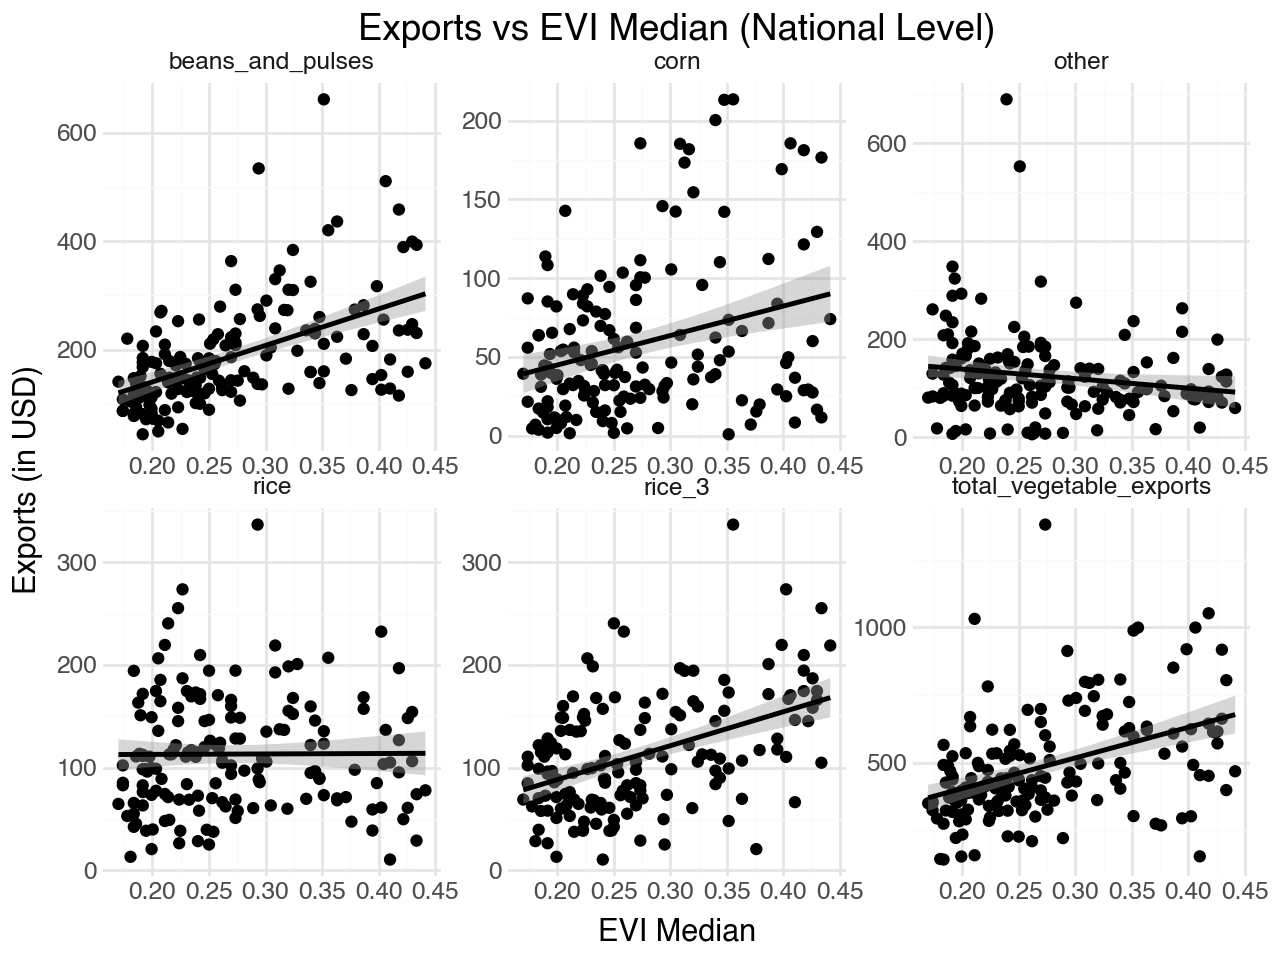

In [38]:
evi_adm0_monthly = (
    evi_adm0_raw.groupby(pd.Grouper(freq="MS")).agg({"EVI": "median"}).pipe(clean_names)
)

(
    exports.set_index("date")
    .join(evi_adm0_monthly, how="inner")
    .assign(
        total_vegetable_exports=lambda df: df["total_vegetable_exports"].shift(6),
        beans_and_pulses=lambda df: df["beans_and_pulses"].shift(6),
        corn=lambda df: df["corn"].shift(6),
        rice=lambda df: df["rice"].shift(6),
        rice_3=lambda df: df["rice"].shift(3),
    )
    .reset_index()
    .melt(
        id_vars=["date", "period", "evi"],
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="evi", y="value")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("variable", ncol=3, scales="free")
    + p9.labs(
        title="Exports vs EVI Median (National Level)",
        x="EVI Median",
        y="Exports (in USD)",
    )
    + p9.theme_minimal()
)

## NO2

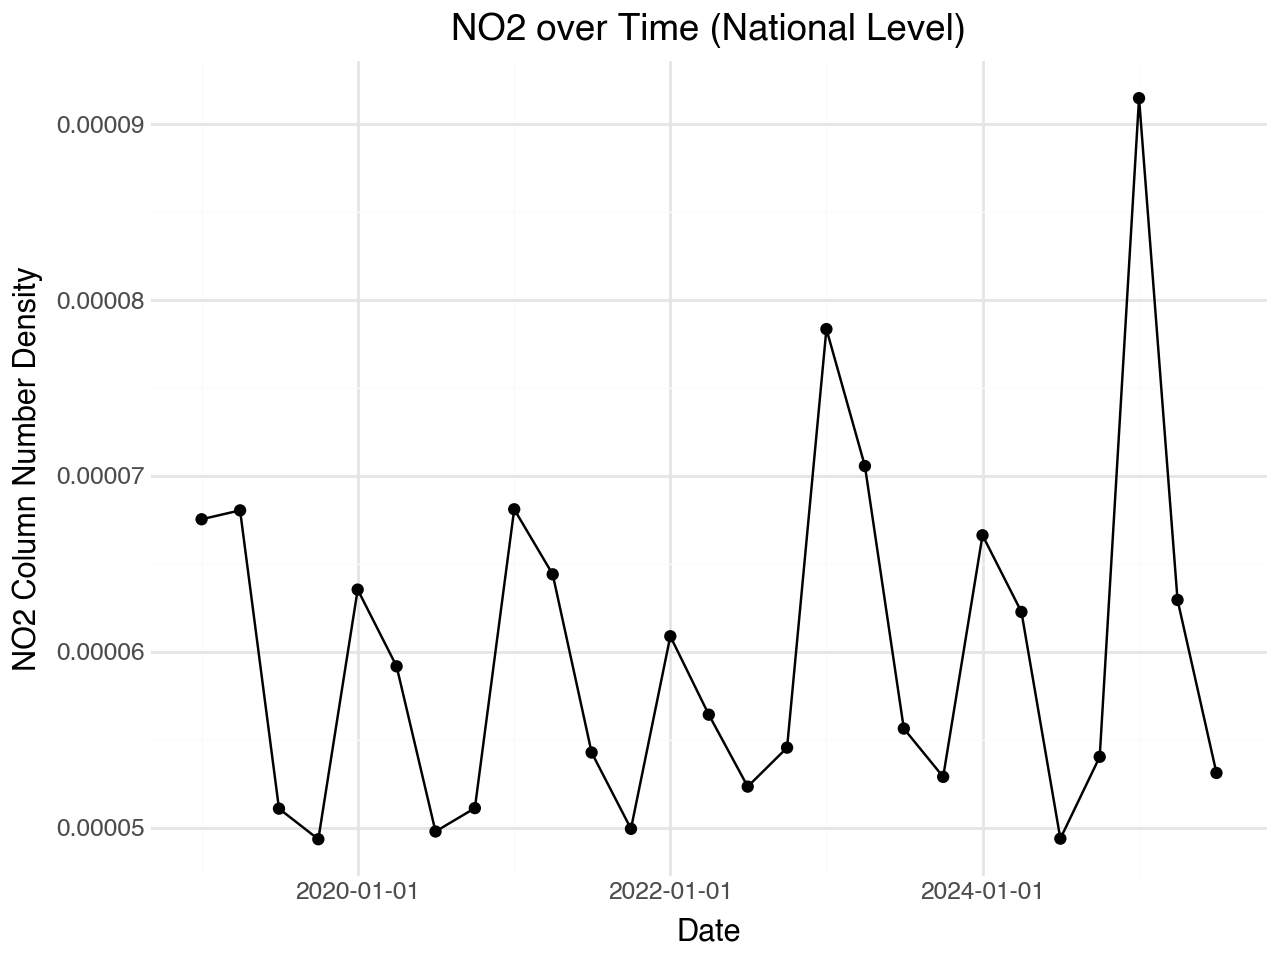

In [39]:
(
    no2_adm0.reset_index().pipe((p9.ggplot, "data"))
    + p9.aes(x="date", y="no2")
    + p9.geom_point()
    + p9.geom_line()
    # + p9.scale_x_datetime(date_labels="%Y", date_breaks="3 year")
    + p9.labs(
        title="NO2 over Time (National Level)",
        x="Date",
        y="NO2 Column Number Density",
    )
    + p9.theme_minimal()
)

### Admin Level 0

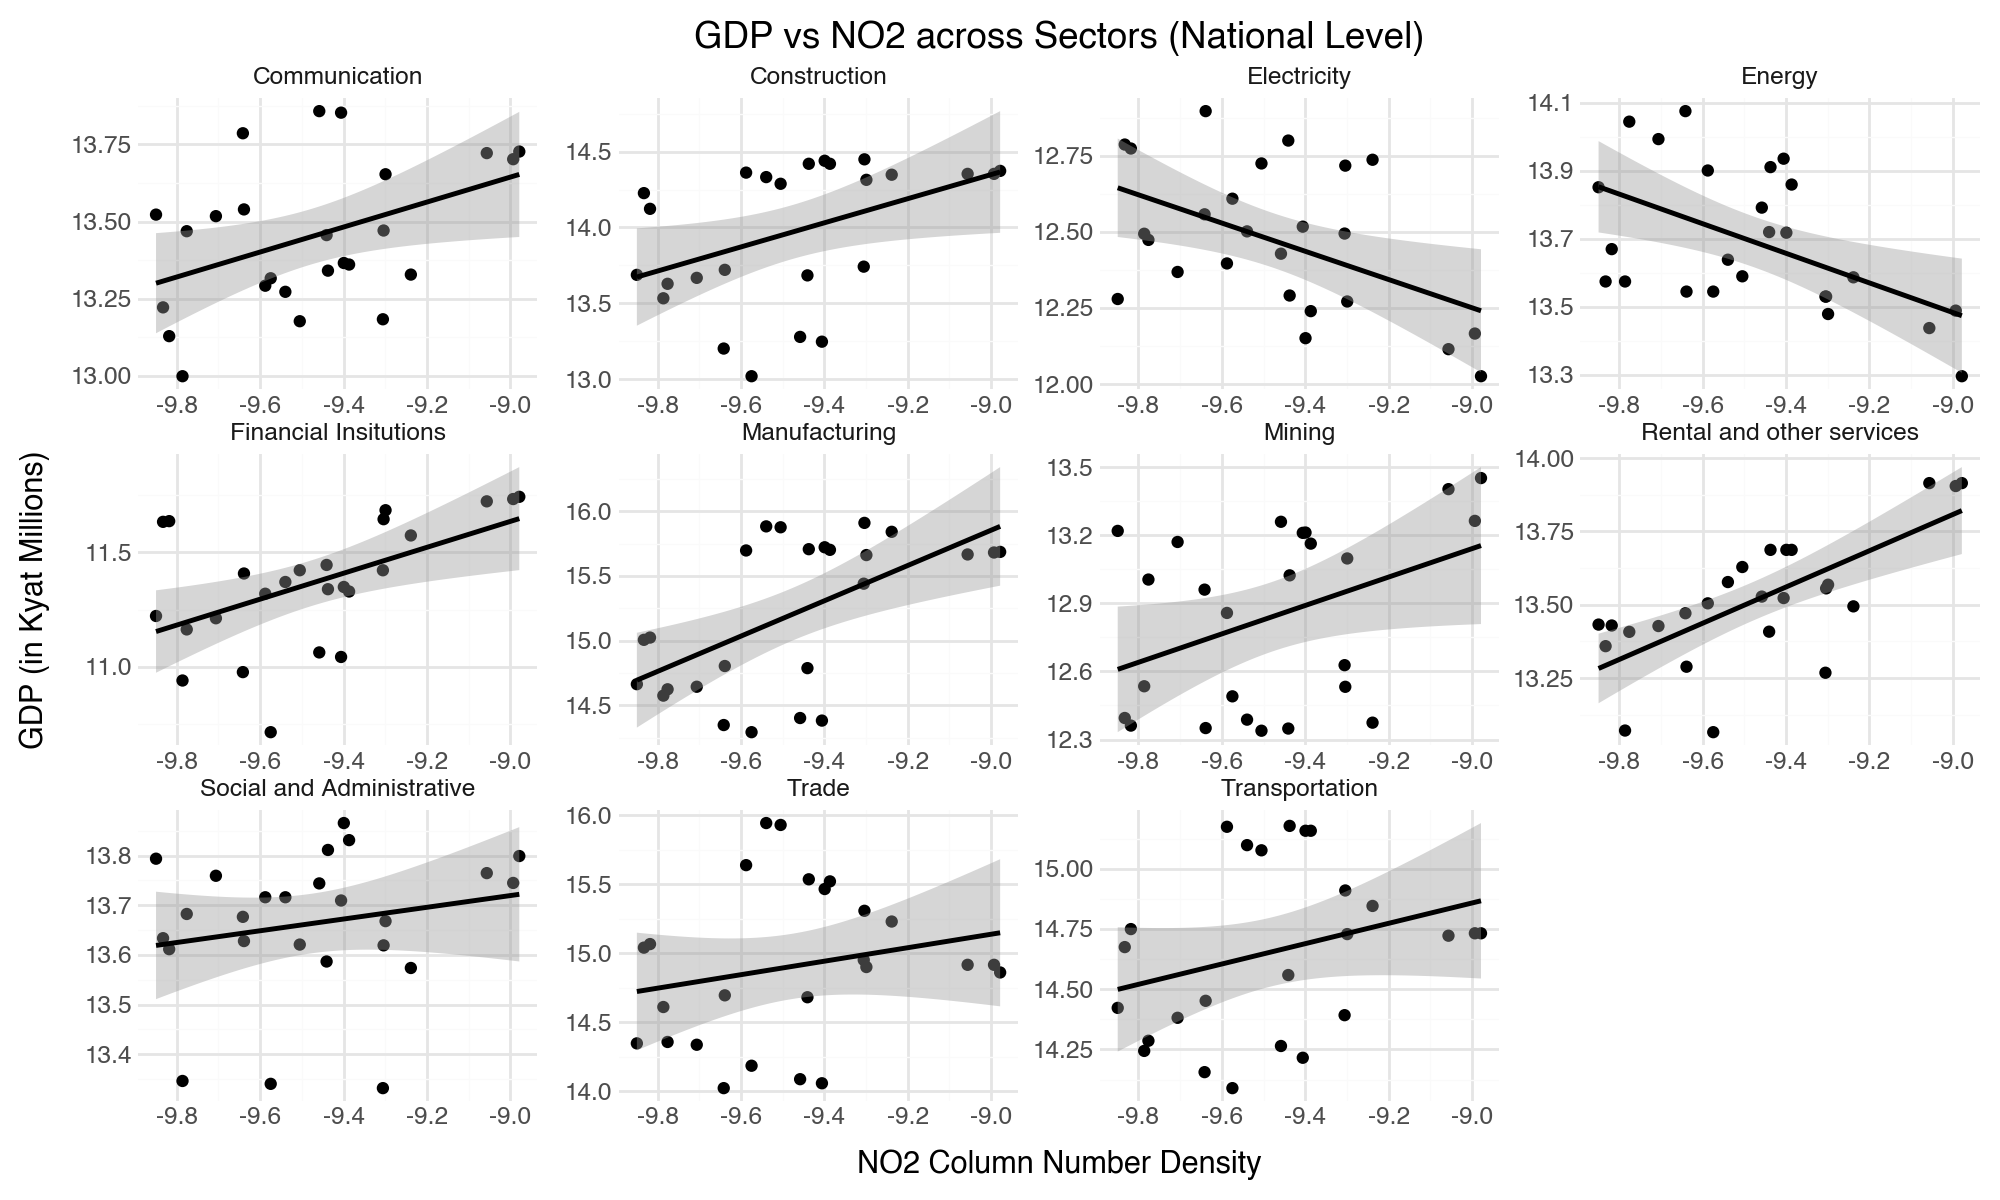

In [40]:
(
    gdp_quarterly_complete.reset_index()
    .merge(
        no2_adm1.reset_index()
        .query("adm1_name == ['Yangon']")
        # .query("adm1_name == ['Mandalay', 'Yangon', 'Sagaing']")
        .groupby("date")
        .agg({"no2": "mean"})
        .reset_index(),
        on="date",
    )
    # .merge(no2_adm0.reset_index(), on="date")
    .assign(
        no2_lag_1=lambda df: df["no2"].shift(1),
        no2_lag_2=lambda df: df["no2"].shift(2),
        no2_std=lambda df: StandardScaler().fit_transform(df[["no2"]]),
        no2_lag_1_std=lambda df: StandardScaler().fit_transform(df[["no2_lag_1"]]),
        no2_lag_2_std=lambda df: StandardScaler().fit_transform(df[["no2_lag_2"]]),
    )
    .query('sub_group != "Agriculture"')
    .assign(
        gdp_log=lambda df: np.log(df["gdp"]),
        no2_log=lambda df: np.log(df["no2"]),
        no2_lag_1_log=lambda df: np.log(df["no2_lag_1"]),
        no2_lag_2_log=lambda df: np.log(df["no2_lag_2"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_log", y="gdp_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("economic_activity", scales="free", ncol=4)
    + p9.labs(
        title="GDP vs NO2 across Sectors (National Level)",
        x="NO2 Column Number Density",
        y="GDP (in Kyat Millions)",
    )
    + p9.theme_minimal()
    + p9.theme(figure_size=(10, 6))
)

In [41]:
no2_indicators = (
    gdp_mft_quarterly.join(no2_adm0, how="left")
    .join(gdp_svc_quarterly, how="left")
    .join(ntl_adm0, how="left")
    .assign(
        no2_lag_1=lambda df: df["no2"].shift(1),
        no2_lag_2=lambda df: df["no2"].shift(2),
        no2_std=lambda df: StandardScaler().fit_transform(df[["no2"]]),
        no2_lag_1_std=lambda df: StandardScaler().fit_transform(df[["no2_lag_1"]]),
        no2_lag_2_std=lambda df: StandardScaler().fit_transform(df[["no2_lag_2"]]),
    )
)
no2_indicators.tail()

gdp_mft  gdp_mft_lag_1  gdp_mft_lag_2       no2  \
date                                                               
2024-01-01  9.600970e+06   1.019290e+07   5.106123e+06  0.000067   
2024-04-01  4.181992e+06   9.600970e+06   1.019290e+07  0.000062   
2024-07-01  5.017848e+06   4.181992e+06   9.600970e+06  0.000049   
2024-10-01  1.023193e+07   5.017848e+06   4.181992e+06  0.000054   
2025-01-01  9.689597e+06   1.023193e+07   5.017848e+06  0.000091   

                 gdp_svc  gdp_svc_lag_1  gdp_svc_lag_2  ntl_mean  \
date                                                               
2024-01-01  8.571614e+06   1.194872e+07   5.884851e+06  0.082295   
2024-04-01  5.666039e+06   8.571614e+06   1.194872e+07  0.114350   
2024-07-01  6.016582e+06   5.666039e+06   8.571614e+06  0.130503   
2024-10-01  1.169164e+07   6.016582e+06   5.666039e+06  0.066086   
2025-01-01  8.474285e+06   1.169164e+07   6.016582e+06  0.063375   

                 ntl_sum  ntl_sum_lag_1  ntl_sum_lag_2  no2_lag_1  no2_lag_2  \
date                                                                           
2024-01-01  1.102821e+06   1.085608e+06   1.217865e+06   0.000053   0.000056   
2024-04-01  1.085608e+06   1.217865e+06   6.640315e+05   0.000067   0.000053   
2024-07-01  1.217865e+06   6.640315e+05   6.369433e+05   0.000062   0.000067   
2024-10-01  6.640315e+05   6.369433e+05   1.197890e+06   0.000049   0.000062   
2025-01-01  6.369433e+05   1.197890e+06   9.006716e+05   0.000054   0.000049   

             no2_std  no2_lag_1_std  no2_lag_2_std  
date                                                
2024-01-01  0.650694      -0.739904      -0.414237  
2024-04-01  0.218089       0.991350      -0.755570  
2024-07-01 -1.061160       0.441926       0.952487  
2024-10-01 -0.599415      -1.182759       0.410425  
2025-01-01  3.117031      -0.596329      -1.192493

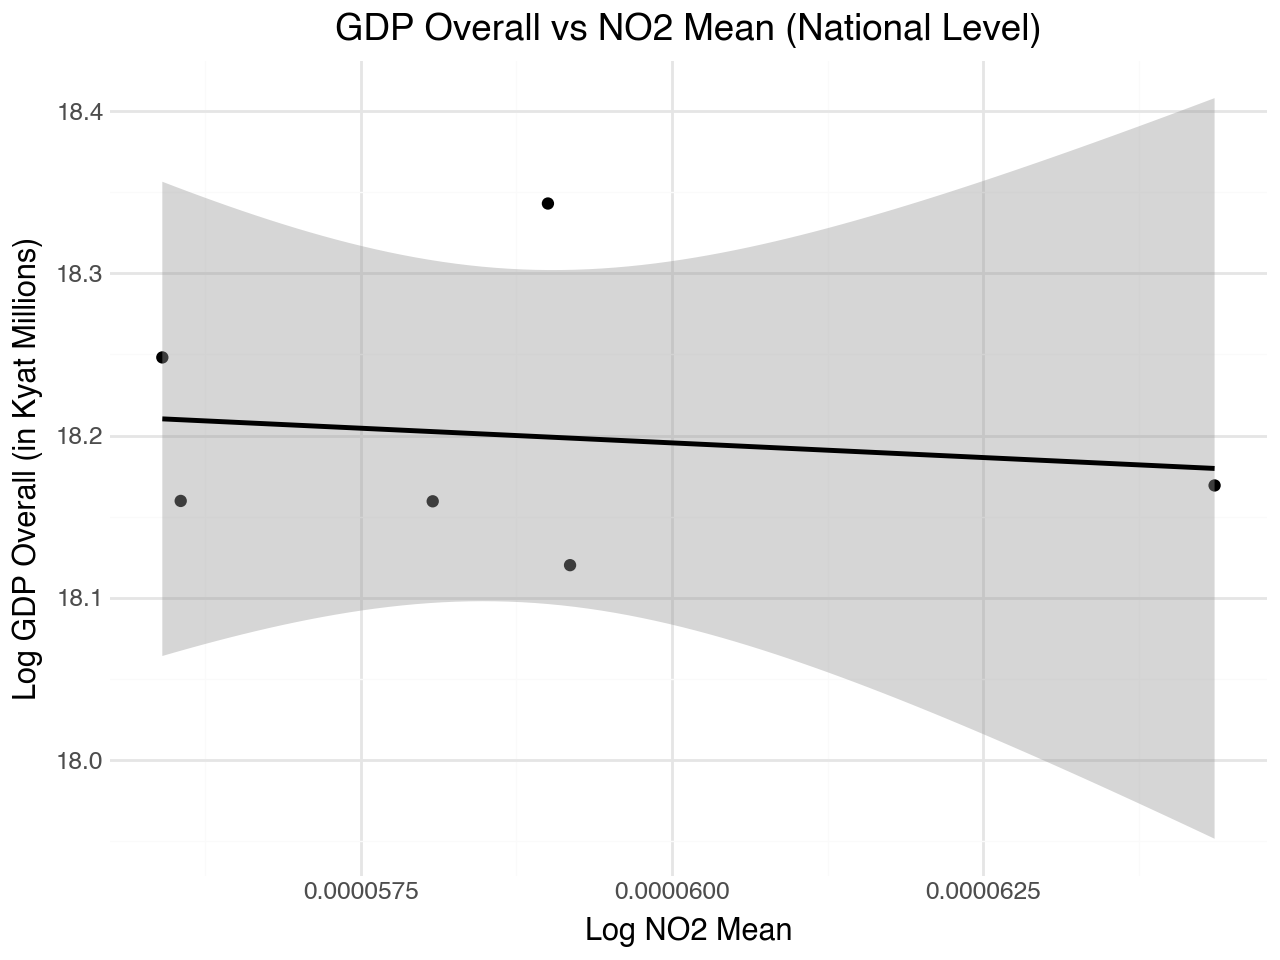

In [42]:
no2_adm0_annual = (
    no2_adm3_raw.assign(date=lambda df: pd.to_datetime(df["date"]))
    .pipe(clean_names)
    .set_index("date")
    .groupby([pd.Grouper(freq="YS")])
    .agg({"no2_column_number_density": "mean"})
    .rename(columns={"no2_column_number_density": "no2"})
)

(
    no2_adm0_annual.join(gdp_overall, how="inner")
    .reset_index()
    .assign(
        no2_log=lambda df: np.log1p(df["no2"]),
        gdp_overall_log=lambda df: np.log1p(df["gdp_overall"]),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_log", y="gdp_overall_log")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Overall vs NO2 Mean (National Level)",
        x="Log NO2 Mean",
        y="Log GDP Overall (in Kyat Millions)",
    )
    + p9.theme_minimal()
)

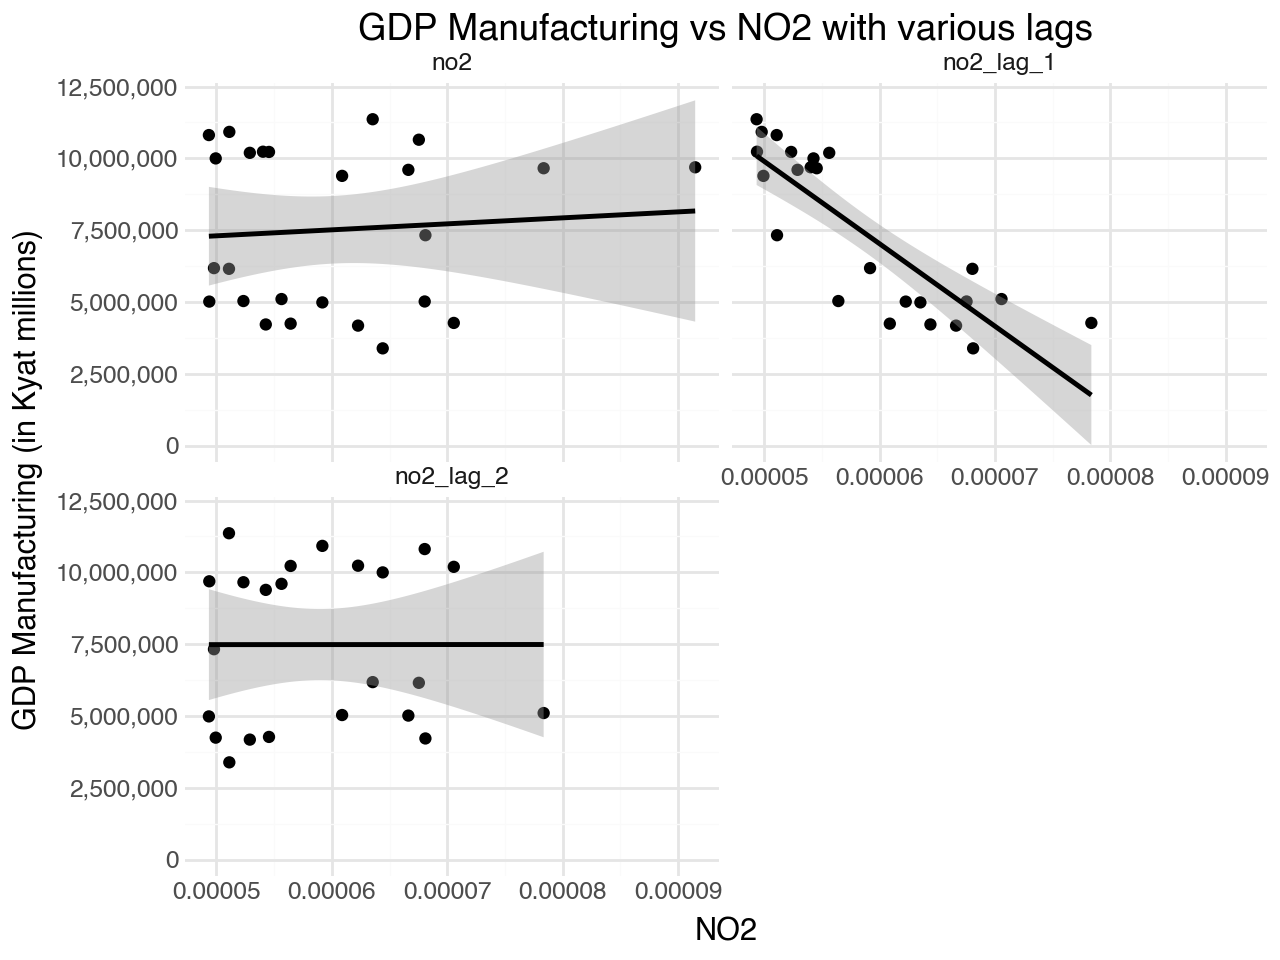

In [43]:
(
    no2_indicators.filter(["gdp_mft", "no2", "no2_lag_1", "no2_lag_2"])
    .reset_index()
    .melt(id_vars=["gdp_mft", "date"])
    .dropna(subset=["value"])
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_mft")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="GDP Manufacturing vs NO2 with various lags",
        x="NO2",
        y="GDP Manufacturing (in Kyat millions)",
    )
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.theme_minimal()
)

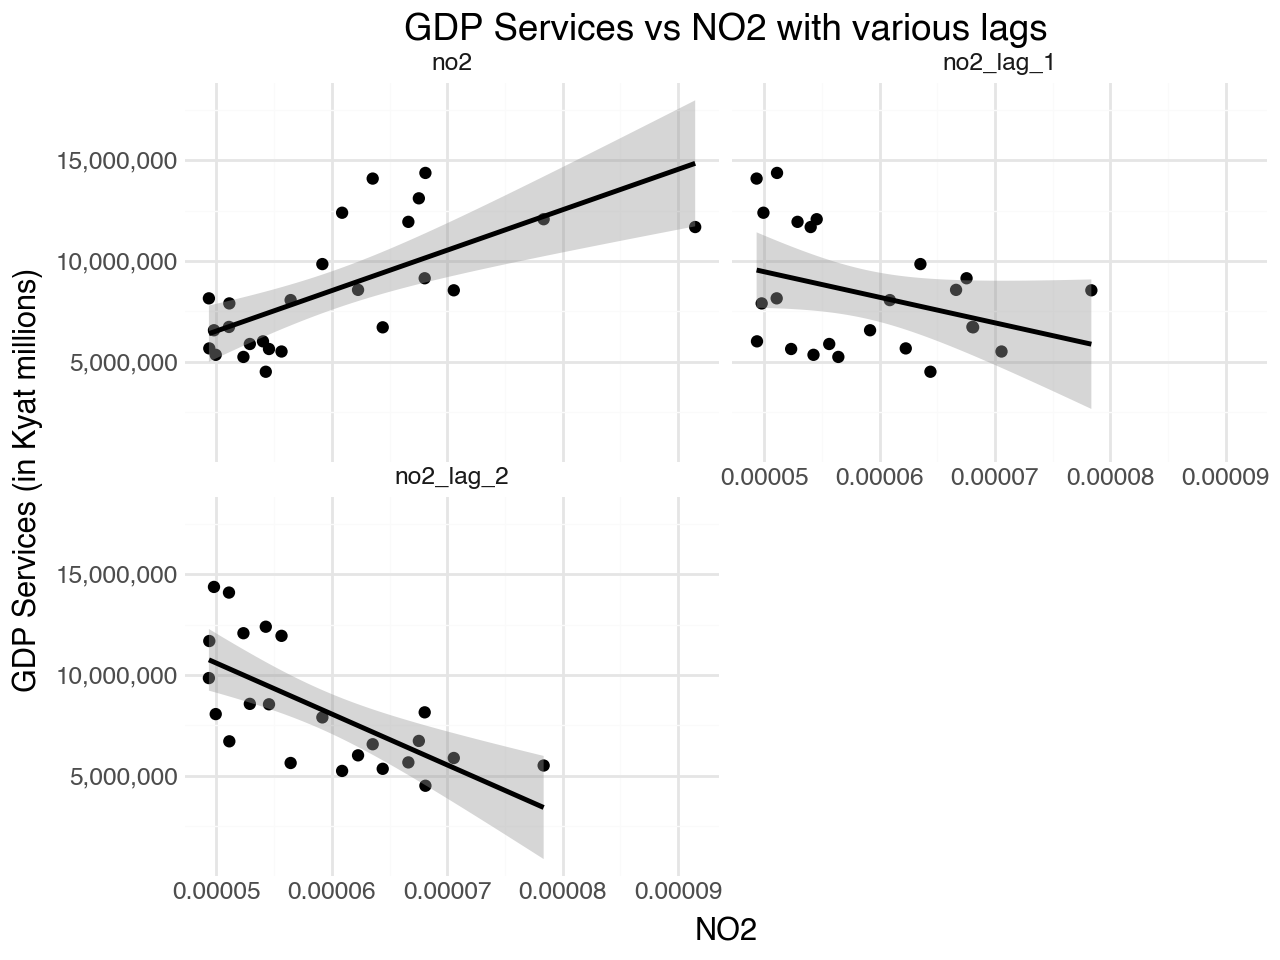

In [44]:
(
    no2_indicators.filter(["gdp_svc_lag_1", "no2", "no2_lag_1", "no2_lag_2"])
    .reset_index()
    .melt(id_vars=["gdp_svc_lag_1", "date"])
    .dropna(subset=["value"])
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="value", y="gdp_svc_lag_1")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.facet_wrap("variable", ncol=2)
    + p9.labs(
        title="GDP Services vs NO2 with various lags",
        x="NO2",
        y="GDP Services (in Kyat millions)",
    )
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.theme_minimal()
)

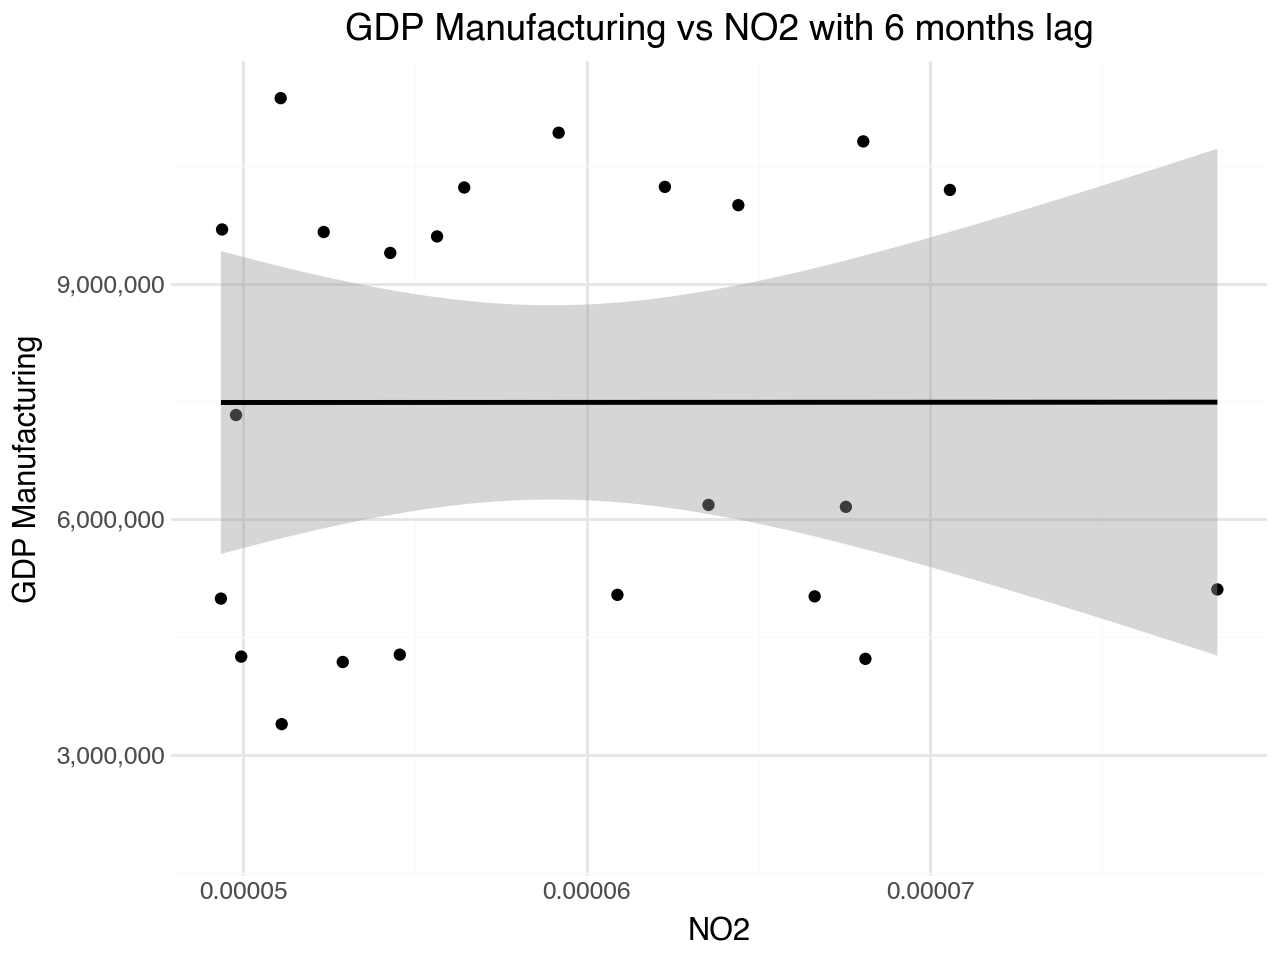

In [45]:
(
    no2_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_lag_2", y="gdp_mft")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NO2 with 6 months lag",
        x="NO2",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

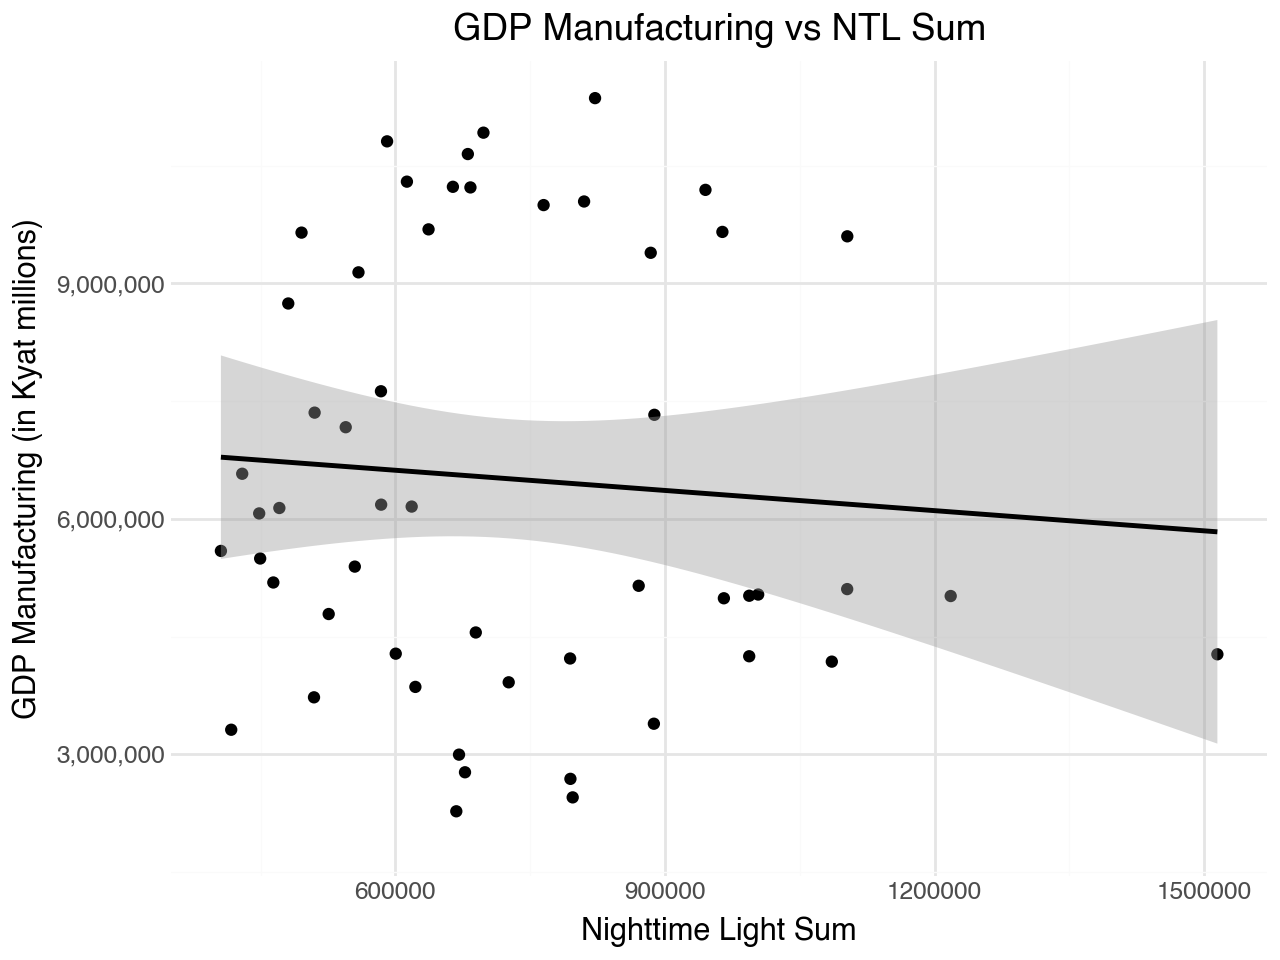

In [46]:
(
    no2_indicators.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_sum", y="gdp_mft")
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NTL Sum",
        x="Nighttime Light Sum",
        y="GDP Manufacturing (in Kyat millions)",
    )
    + p9.theme_minimal()
)

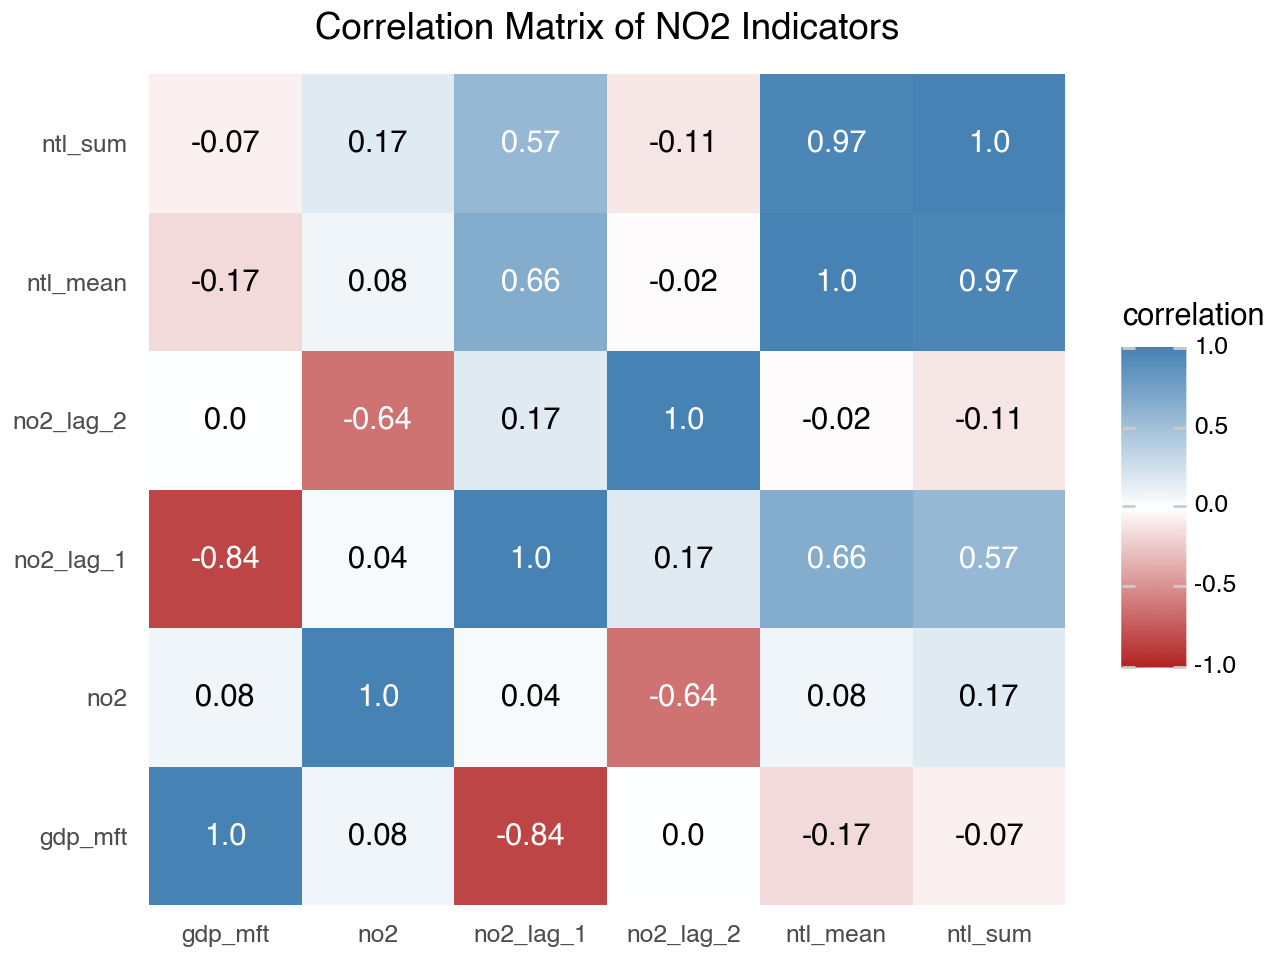

In [47]:
(
    no2_indicators.filter(
        [
            "gdp_mft",
            "no2",
            "no2_lag_1",
            "no2_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of NO2 Indicators", x="", y="")
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [48]:
mod_1 = smf.ols("gdp_mft ~ no2", data=no2_indicators).fit()
mod_2 = smf.ols("gdp_mft ~ ntl_mean + no2", data=no2_indicators).fit()
mod_3 = smf.ols(
    "gdp_mft ~ ntl_mean + no2 + no2_lag_1 + no2_lag_2", data=no2_indicators
).fit()

Stargazer([mod_1, mod_2, mod_3])

In [49]:
mod_4 = smf.ols(
    "gdp_mft ~ ntl_mean_std + no2_std + no2_lag_1_std + no2_lag_2_std",
    data=no2_indicators,
).fit()

Stargazer([mod_4])

PatsyError: Error evaluating factor: NameError: name 'ntl_mean_std' is not defined
    gdp_mft ~ ntl_mean_std + no2_std + no2_lag_1_std + no2_lag_2_std
              ^^^^^^^^^^^^

In [ ]:
no2_indicators_clean = no2_indicators.dropna()
X = no2_indicators_clean[["no2", "ntl_mean", "no2_lag_1", "no2_lag_2"]]
y = no2_indicators_clean["gdp_mft"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)

### Admin Level 1

In [ ]:
no2_indicators_adm1 = (
    gdp_mft_quarterly_adm1.join(no2_adm1, how="left")
    .join(ntl_adm1, how="left")
    .assign(
        gdp_mft_c=lambda df: df["gdp_mft"] - df["gdp_mft"].mean(),
        no2_std=lambda df: StandardScaler().fit_transform(df[["no2"]]),
        ntl_mean_std=lambda df: StandardScaler().fit_transform(df[["ntl_mean"]]),
        ntl_sum_std=lambda df: StandardScaler().fit_transform(df[["ntl_sum"]]),
    )
    .reset_index()
    .sort_values(["adm1_name", "date"])
    .groupby("adm1_name")
    .apply(
        lambda df: df.assign(
            no2_lag_1=df["no2"].shift(1),
            no2_lag_2=df["no2"].shift(2),
            no2_lag_1_std=lambda dff: StandardScaler().fit_transform(
                dff[["no2_lag_1"]]
            ),
            no2_lag_2_std=lambda dff: StandardScaler().fit_transform(
                dff[["no2_lag_2"]]
            ),
            ntl_mean_lag_1=df["ntl_mean"].shift(1),
        ),
    )
    .set_index(["adm1_name", "date"])
)

no2_indicators_adm1.tail()

In [ ]:
(
    no2_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="no2", y="gdp_mft")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NO2",
        x="NO2",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

In [ ]:
(
    no2_indicators_adm1.assign(
        no2_log=lambda df: np.log1p(df["no2"]),
        gdp_mft_log=lambda df: np.log1p(df["gdp_mft"]),
    ).pipe((p9.ggplot, "data"))
    + p9.aes(x="no2_log", y="gdp_mft_log")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.labs(
        title="GDP Manufacturing vs NO2",
        x="NO2",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

In [ ]:
(
    no2_indicators_adm1.pipe((p9.ggplot, "data"))
    + p9.aes(x="ntl_mean", y="gdp_mft")
    + p9.geom_point(size=2, alpha=0.5, stroke=0)
    + p9.geom_smooth(method="lm")
    + p9.scale_y_continuous(labels=lambda label: ["{:,}".format(int(v)) for v in label])
    + p9.labs(
        title="GDP Manufacturing vs NTL Mean",
        x="Nighttime Lights (NTL) Mean",
        y="GDP Manufacturing",
    )
    + p9.theme_minimal()
)

In [ ]:
(
    no2_indicators_adm1.filter(
        [
            "gdp_mft",
            "no2",
            "no2_lag_1",
            "no2_lag_2",
            "ntl_mean",
            "ntl_sum",
        ]
    )
    .corr()
    .reset_index()
    .melt(id_vars=["index"], var_name="variable", value_name="correlation")
    .rename(columns={"index": "variable_1", "variable": "variable_2"})
    .assign(
        correlation=lambda df: df["correlation"].round(2),
        text_color=lambda df: df["correlation"].apply(
            lambda x: "white" if abs(x) > 0.5 else "black"
        ),
    )
    .pipe((p9.ggplot, "data"))
    + p9.aes(x="variable_1", y="variable_2", fill="correlation")
    + p9.geom_tile()
    + p9.scale_fill_gradient2(
        low="firebrick", mid="white", high="steelblue", limits=(-1, 1)
    )
    + p9.geom_text(p9.aes(label="correlation", color="text_color"))
    + p9.scale_color_identity()
    + p9.labs(title="Correlation Matrix of Indicators", x="", y="")
    + p9.theme_minimal()
    + p9.theme(panel_grid_major=p9.element_blank())
)

In [ ]:
mod_3 = smf.ols(
    "np.log(gdp_mft) ~ np.log(ntl_sum) + np.log(no2)",
    data=no2_indicators_adm1,
).fit()

mod_3.summary()

In [ ]:
mod_3 = smf.ols(
    "gdp_mft ~ no2",
    data=no2_indicators_adm1,
).fit()

mod_3.summary()

In [ ]:
no2_indicators_adm_1_clean = no2_indicators_adm1.dropna()
X = no2_indicators_adm_1_clean[["no2", "ntl_mean", "no2_lag_1", "no2_lag_2"]]
y = no2_indicators_adm_1_clean["gdp_mft"]

model = GradientBoostingRegressor()
model.fit(X, y)

explainer_xgb = shap.Explainer(model)
shap_values = explainer_xgb(X)

shap.plots.beeswarm(shap_values)